# Tarea 2: Uso de técnicas de PLN para representar texto

**Ricardo Calvo Perez - A01028889**

### 0. Importar librerias

In [85]:
import sys
!"{sys.executable}" -m pip install gensim nrclex nltk scipy spacy seaborn scikit-learn transformers accelerate
!"{sys.executable}" -m spacy download en_core_web_sm

!wget -nc https://raw.githubusercontent.com/aditeyabaral/lok-sabha-election-twitter-analysis/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt -P /content/
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.preprocessing import normalize
from scipy.sparse import hstack


nltk.download('stopwords')
import os
from dotenv import load_dotenv
load_dotenv()



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.0/12.8 MB 393.8 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 653.6 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.5/12.8 MB 1.9 MB/s eta 0:00:07
     - -------------------------------------- 0.6/12.8 MB 2.2 MB/s eta 0:00:06
     --- ------------------------------------ 1.1/12.8 MB 3.2 MB/s eta 0:00:04
     ---- ----------------------------------- 1.4/12.8 MB 3.8 MB/s eta 0:00:04
     ----- ---------------------------------- 1.6/12.8 MB 3.9 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 5.2 MB/s eta 0:00:03
     ------- -------------------------------- 2.5/12.8 MB 4.8 MB/s eta 0:00:03
     ---------- ----------------------------- 3.2/12.8 M


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\calvo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
labels = []
raw_X = []

base_path = os.getenv("NAT_LANG_PATH")
original_training = os.path.join(
    base_path,
    'Data',
    'originallTraining.txt'
)


with open(original_training, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            labels.append(parts[2])
            raw_X.append('\t'.join(parts[3:]))

for line in raw_X[:10]:
    print(line)

unique_labels = list(set(labels))
print("\nUnique labels:")
print(unique_labels)

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)
Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)
with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.
Talking about ACT's && SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.
They may have a SuperBowl in Dallas, but Dallas ain't winning a SuperBowl. Not with that quarterback and owner. @S4NYC @RasmussenPoll
Im bringing the monster load of candy tomorrow, I just hope it doesn't get all squiched
Apple software, retail chiefs out in overhaul: SAN FRANCISCO Apple Inc CEO Tim Cook on Monday replaced the heads... http://bit.ly/XQEhJU
#Livewire Nadal confirmed for Mexican Open in February: Rafael Nadal is set to play at the Me... http://bit.ly/WY4Vjy  #LiveWireAthletics
#Iran US delisting MKO from global terrorists 

In [3]:
from tqdm.auto import trange
import re, spacy
from nltk.corpus import stopwords

def clean_text(raw_x, leave_caps = True, custom_stopwords = None, possible_emojis = None, intesifiers = None, negators = None, emoji_map = None, return_all = False):

  processed_caps_X, processed_regex_X, processed_stopwords_X = [], [], []
  processed_special_characters_X, processed_POS_tags_X, processed_emojis_X = [], [], []

  # Step 1: Process caps
  # This loop processes each line in raw_X, converting words to lowercase
  # except when the word is fully uppercase and leave_caps is True.
  for i in trange(len(raw_x), desc="Step 1: Process caps"):
    line = raw_x[i]
    words = line.split()  # Split the line into individual words
    processed_line = []   # Temporary list to hold processed words

    for word in words:
        # If the word is fully uppercase and we want to preserve caps, keep it as-is
        if word.isupper() and leave_caps:
            processed_line.append(word)
        else:
            # Otherwise, convert the word to lowercase
            processed_line.append(word.lower())

    # Join processed words back into a single string and add to processed_caps_X
    processed_caps_X.append(" ".join(processed_line))

  # Step 2: Process URLs and mentions
  # This loop cleans each line in processed_caps_X by removing URLs and @mentions.
  for i in trange(len(processed_caps_X), desc="Step 2: Process URLs & mentions"):
      line = processed_caps_X[i]
      # Remove URLs starting with "http" followed by any non-space characters
      line = re.sub(r'http\S+', '', line)
      # Remove URLs starting with "www" followed by any characters
      line = re.sub(r'www.+', '', line)

      # Remove mentions that start with '@' followed by non-space characters
      line = re.sub(r'@\S+', '', line)

      # Append the cleaned line to processed_regex_X
      processed_regex_X.append(line)

  # Step 3: Process stop-words
  # This step removes common stopwords from the text, but keeps certain useful words like "not" or "very".
  if custom_stopwords is None:
      # Load default English stopwords from NLTK
      stopwords_en = set(stopwords.words("english"))
      # Words to keep even though they appear in standard stopword lists
      keep_words = {
          "no","not","never","none","nobody","nothing","neither","nor","nowhere",
          "hardly","barely","scarcely","very","too","so","quite","really","super","won"
      }

      # Final stopword set: all stopwords except those in keep_words
      custom_stopwords = stopwords_en - keep_words
  else:
      # Ensure the provided stopwords are a set for faster lookup
      custom_stopwords = set(custom_stopwords)

  # Loop through each cleaned line and remove stopwords
  for i in trange(len(processed_regex_X), desc="Step 3: Process stop-words"):
      line = processed_regex_X[i]
      tokens = line.split()      # split line into words
      kept_tokens = []           # temporary list to store non-stopwords

      for t in tokens:
          # Compare lowercase version to handle capitalization differences
          if t.lower() not in custom_stopwords:
              kept_tokens.append(t)                # keep non-stopword tokens

      # Join remaining words back into a cleaned line
      processed_stopwords_X.append(" ".join(kept_tokens))

  # Step 4: Process special characters
  # This step normalizes punctuation and emojis, removes unwanted symbols,
  # and ensures text remains clean and readable for further processing.
  if possible_emojis is None:
      # Default set of common emoticons to protect before cleaning
      possible_emojis = sorted({
          ":-)", ":-D", ":-(", ";-)", ":-/", ":/", ":)", "(:", ":D", ":(", "):", "(;", ";)",
          ":P", ":-P", "<3", ":'(", ":'-(", ":|", ":-|", ":o", ":O", ":-o", ":-O", ":*", ":-*",
          ":p", ":-p", ";p", ";P", "xD", "XD", "xDD", "XDD", "T_T", "TT_TT", "u_u", "U_U",
          "-_-", "^_^", "^-^", "o.o", "O_O", "x_x", "X_X", "~_~"
      }, key=len, reverse=True)
  else:
      # If a custom emoji list is given, sort by length for proper matching
      possible_emojis = sorted(possible_emojis, key=len, reverse=True)

  for i in trange(len(processed_stopwords_X), desc="Step 4: Process special chars"):
      line = processed_stopwords_X[i]
      # 0) Normalize smart quotes and other variants for consistency
      line = (line.replace("’", "'").replace("‘", "'").replace("`", "'")
                  .replace("“", '"').replace("”", '"'))

      # 1) Temporarily replace emoticons with markers to prevent deletion
      protected = {}
      for j, emo in enumerate(possible_emojis):
          if emo in line:
              marker = f"EMO_{j}_TOKEN"
              protected[marker] = emo
              line = line.replace(emo, marker)

      # 2) Remove commas used as thousand separators (e.g., "10,000" → "10000")
      line = re.sub(r'(?<=\d),(?=\d)', '', line)

      # 3) Replace exclamation and question sequences with a space to prevent word merging
      line = re.sub(r'[!?]+', ' ', line)

      # 4) Replace quotes and dashes with spaces to separate joined words
      line = re.sub(r'["“”]+', ' ', line)
      line = re.sub(r'[–—]+', ' ', line)

      # 5) Remove all non-word, non-space, non-apostrophe characters
      line = re.sub(r"[^\w\s']+", ' ', line)

      # 6) Remove stray apostrophes not between letters
      line = re.sub(r"(?<![A-Za-z])'(?![A-Za-z])", ' ', line)

      # 7) Collapse multiple spaces into one and trim edges
      line = re.sub(r'\s+', ' ', line).strip()

      # 8) Restore emoticons from protected markers
      for marker, emo in protected.items():
          line = line.replace(marker, emo)

      # Add the fully cleaned line to the final list
      processed_special_characters_X.append(line)

  # Step 6: Process PoS Tags
  # Step 7: Process Lemmatization
  # Load the small English model with NER disabled for speed.
  nlp_en = spacy.load("en_core_web_sm", disable=["ner"])
  # Prepare intensifiers
  if intesifiers is None:
      # Default set of English/Spanish intensifiers
      intesifiers = {
          "very","really","so","too","quite","super","extremely","re",
          "muy","súper","tan","bastante"
      }
  else:
      # Ensure fast membership checks
      intensifiers = set(intensifiers)

  # Prepare negators
  if negators is None:
      # Default set of English/Spanish negators
      negators = {
          "no","not","never","none","nobody","nothing","neither","nor","nowhere",
          "hardly","barely","scarcely",
          "nunca","jamás","ni","tampoco","sin"
      }
  else:
      # Ensure fast membership checks
      negators = set(negators)

  for i in trange(len(processed_special_characters_X), desc="Step 6–7: Process POS & Lemma"):
      line = processed_special_characters_X[i]
      # Process the tweet with spaCy (tokenization, lemma, PoS info)
      doc = nlp_en(line)
      out = []
      i_tok = 0
      while i_tok < len(doc):
          tok = doc[i_tok]
          low = tok.text.lower()

          # --- 1.6 PoS Tags (Negation & Intensifiers) ---
          # If token is a negator or intensifier and has a next token,
          # merge them into a single token like "not_good" or "very_happy".
          if (low in negators or low in intesifiers) and i_tok+1 < len(doc):
              next_token = doc[i_tok+1].lemma_.lower()  # use lemma of next word
              out.append(f"{low}_{next_token}")
              i_tok += 2
              continue

          # --- 1.7 Lemmatization ---
          # For normal tokens, append the lemma in lowercase
          # (e.g., "running" → "run").
          lemma = tok.lemma_.lower()

          if low == "'s":   # it's, he's, she's, that's+
              lemma = "is"
          elif low == "'m":  # I'm
              lemma = "am"
          elif low == "'re": # they're, you're, we're
              lemma = "are"
          elif low == "'ll": # I'll, he'll, she'll, they'll
              lemma = "will"
          elif low == "'ve": # I've, they've, we've, you've
              lemma = "have"
          elif low == "'d":  # I'd, he'd, she'd, they'd
              # puede ser "would" o "had", contexto dependiente → en análisis simple usamos "would"
              lemma = "would"

          out.append(lemma)
          i_tok += 1

      processed_POS_tags_X.append(" ".join(out))

  # Step 8: Process emojis
  if emoji_map is None:
      emoji_map = {
    # Positive
    ":-)": "happy", ":)": "happy", "(:": "happy",
    ":D": "smile", ":-D": "smile", "xD": "smile", "XD": "smile", "xDD": "smile", "XDD": "smile",
    "<3": "love",

    # Negative
    ":-(": "sad", ":(": "sad", "):": "sad",
    ":'(": "cry", ":'-(": "cry",
    "T_T": "cry", "TT_TT": "cry",
    "x_x": "dead", "X_X": "dead",
    "-_-": "annoyed",

    # Neutral / uncertain / surprised
    ":-/": "uncertain", ":/": "uncertain",
    ":|": "neutral", ":-|": "neutral",
    ":o": "surprised", ":O": "surprised",
    ":-o": "surprised", ":-O": "surprised",
    "o.o": "surprised", "O_O": "surprised",

    # Playful / wink
    ";-)": "wink", ";)": "wink", "(;": "wink",
    ":P": "playful", ":-P": "playful", ";P": "playful", ";p": "playful",
    ":p": "playful", ":-p": "playful",

    # Cute / positive
    "^_^": "smile", "^-^": "smile",
    "u_u": "sad", "U_U": "sad",
    "~_~": "tired",
    ":*": "kiss", ":-*": "kiss",
}

  for i in trange(len(processed_POS_tags_X), desc="Step 8: Process emojis"):
        line = processed_POS_tags_X[i]
        for emo, token in emoji_map.items():
            if emo in line:
                line = line.replace(emo, token)
        processed_emojis_X.append(line)

  if return_all:
    return processed_caps_X, processed_regex_X, processed_stopwords_X, processed_special_characters_X, processed_POS_tags_X, processed_emojis_X

  return processed_emojis_X


f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Helper plot to visualize prediction results via confusion matrix

def plot_confusion_matrix(y_true, y_pred, class_names=None, title_prefix="Model"):
    # --- Confusion matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=class_names if class_names else None)
    if class_names is None:
        class_names = [str(c) for c in np.unique(np.concatenate([y_true, y_pred]))]
    n_classes = len(class_names)

    # --- Classification report ---
    print(f"{title_prefix} — classification report")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation="nearest", aspect="auto")
    ax.set_title(f"{title_prefix}\nConfusion Matrix (counts)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(n_classes)); ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(range(n_classes)); ax.set_yticklabels(class_names)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Annotate counts
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black")

    plt.tight_layout()
    plt.show()

    return cm

In [5]:
X_train_texts = clean_text(raw_X)
y_train = labels.copy()

for text in X_train_texts[:10]:
    print(text)

Step 8: Process emojis: 100%|██████████| 6165/6165 [00:00<00:00, 314408.33it/s]

gas house hit 3 39 go chapel hill sit happy
iranian general say israel is iron dome can not deal missile keep talk like may end find out
j davlar 11th main rival team poland hopefully make successful end tough week training tomorrow
talk act is sit is decide want go college apply college everything college stress out
may superbowl dallas dallas be not win superbowl not_quarterback owner
i m bring monster load candy tomorrow hope get squiche
apple software retail chief overhaul san francisco apple inc ceo tim cook monday replace head
livewire nadal confirm mexican open february rafael nadal set play i livewireathletic
iran us delist mko global terrorist list line iran campaign tehran oct 30 irna secretary
expect light moderate rain e visayas cebu bohol samar leyte 30 70 chance rain tonight expect fair weather tomorrow happy


In [6]:
raw_test_X = []
y_test = []

original_test = os.path.join(
    base_path,
    'Data',
    'originalTest.txt'
)


with open(original_test, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            y_test.append(parts[2])
            raw_test_X.append('\t'.join(parts[3:]))

X_test_texts = clean_text(raw_test_X)

for text in X_train_texts[:10]:
    print(text)

Step 8: Process emojis: 100%|██████████| 974/974 [00:00<00:00, 425502.77it/s]

gas house hit 3 39 go chapel hill sit happy
iranian general say israel is iron dome can not deal missile keep talk like may end find out
j davlar 11th main rival team poland hopefully make successful end tough week training tomorrow
talk act is sit is decide want go college apply college everything college stress out
may superbowl dallas dallas be not win superbowl not_quarterback owner
i m bring monster load candy tomorrow hope get squiche
apple software retail chief overhaul san francisco apple inc ceo tim cook monday replace head
livewire nadal confirm mexican open february rafael nadal set play i livewireathletic
iran us delist mko global terrorist list line iran campaign tehran oct 30 irna secretary
expect light moderate rain e visayas cebu bohol samar leyte 30 70 chance rain tonight expect fair weather tomorrow happy


## Bag of Words

Para bag of words estaremos variando los clasificadores para poder ver con que combinación tenemos una mejor exactitud.
Los clasificadores que vamos a usar son:
- Naive Bayes
- SVM Lineal
- Regresión Logistica
- Árboles de decisión

Estos clasificadores se eligieron porque son modelos ampliamente utilizados en tareas de texto cuando se emplean representaciones dispersas como BoW. Naive Bayes y regresión logística son estándares en clasificación de texto por su eficiencia y buen rendimiento. Los SVM lineales suelen ser de los más precisos con vectores de alta dimensionalidad como los que genera Bag of Words. Los árboles de decisión permiten explorar modelos no lineales sin necesidad de ingeniería adicional.

In [7]:
# --- VECTORIZATION ---
# Fit ONLY on train; transform test with the SAME vectorizer
vectorizer = CountVectorizer(binary=False, token_pattern=r"(?u)\b\w[\w']+\b")
X_train = vectorizer.fit_transform(X_train_texts)   # 2D sparse matrix
X_test = vectorizer.transform(X_test_texts)        # 2D sparse matrix

### Bag of words - Naive Bayes

Accuracy: 0.4004106776180698
                      precision    recall  f1-score   support

            negative       0.57      0.18      0.28       179
             neutral       0.42      0.11      0.18       330
           objective       0.07      0.10      0.08        30
objective-OR-neutral       0.13      0.16      0.14        77
            positive       0.44      0.85      0.58       358

            accuracy                           0.40       974
           macro avg       0.33      0.28      0.25       974
        weighted avg       0.42      0.40      0.34       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.569     0.184     0.278       179
             neutral      0.420     0.112     0.177       330
           objective      0.068     0.100     0.081        30
objective-OR-neutral      0.135     0.156     0.145        77
            positive      0.439     0.852     0.579       358



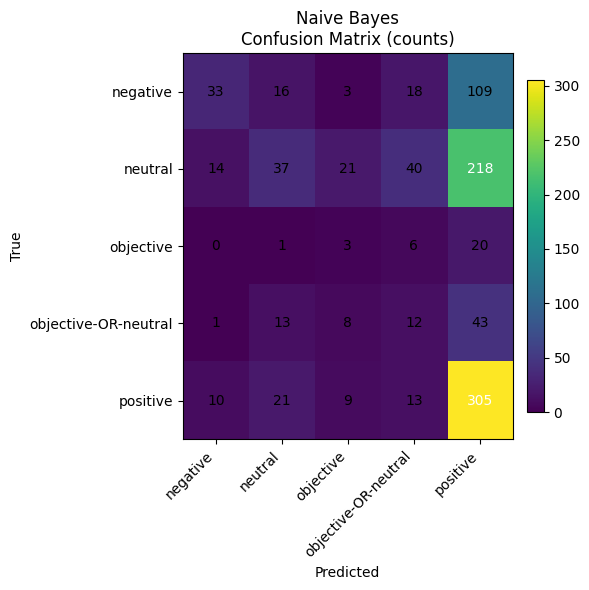

In [8]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                                    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
                                    title_prefix="Naive Bayes")

Como podemos ver en nuestra primera prueba de **bag of words con Naive Bayes**, nuestros resultados no son tan malos, pero tampoco son números de los que estar orgullosos. Los valores de nuestras métricas indican que nuestro mejor atributo es la precisión, mientras que el peor es el recall. Sin embargo, vemos que el recall es muy bueno para nuestra clase positiva, mientras que la mejor precisión se obtiene en la clase negativa.

### Bag of words - Linear SVC

Accuracy: 0.41478439425051333
                      precision    recall  f1-score   support

            negative       0.47      0.33      0.39       179
             neutral       0.41      0.26      0.32       330
           objective       0.04      0.13      0.06        30
objective-OR-neutral       0.16      0.32      0.21        77
            positive       0.61      0.64      0.63       358

            accuracy                           0.41       974
           macro avg       0.34      0.34      0.32       974
        weighted avg       0.47      0.41      0.43       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.472     0.330     0.388       179
             neutral      0.414     0.264     0.322       330
           objective      0.038     0.133     0.059        30
objective-OR-neutral      0.155     0.325     0.210        77
            positive      0.614     0.640     0.627       358



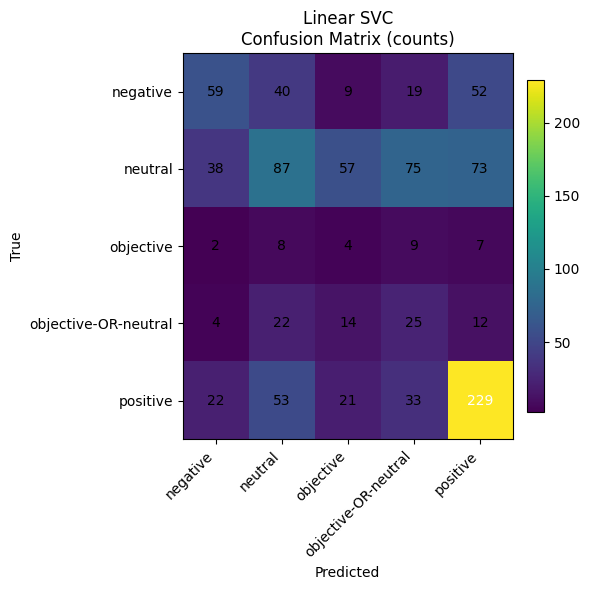

In [9]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

Con la prueba de **Linear SVC** vemos que nuestra exactitud mejora levemente, pasando de 40 % a 41 %. Aunque no es un gran cambio, sí representa una mejora considerable. También podemos observar una gran mejora en nuestros recall, incrementando de manera notable los valores de todas las clases. En cuanto a la precisión, no se aprecia ningún cambio relevante.

### Bag of words - Regresión Logistica

Accuracy: 0.4188911704312115
                      precision    recall  f1-score   support

            negative       0.47      0.36      0.41       179
             neutral       0.43      0.27      0.33       330
           objective       0.07      0.27      0.11        30
objective-OR-neutral       0.15      0.32      0.21        77
            positive       0.64      0.61      0.63       358

            accuracy                           0.42       974
           macro avg       0.35      0.37      0.34       974
        weighted avg       0.48      0.42      0.44       974

Logistic Regression — classification report
                      precision    recall  f1-score   support

            negative      0.468     0.363     0.409       179
             neutral      0.433     0.273     0.335       330
           objective      0.068     0.267     0.108        30
objective-OR-neutral      0.152     0.325     0.207        77
            positive      0.640     0.615     0.627    

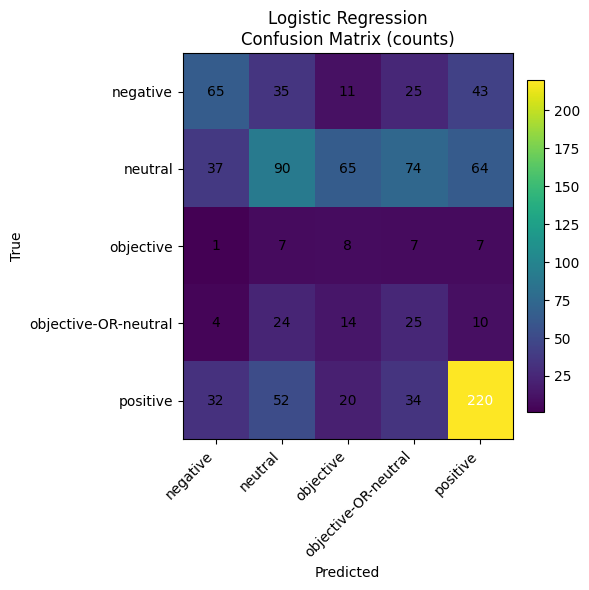

In [10]:
logreg = LogisticRegression(max_iter=10000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
cm = plot_confusion_matrix(y_test, y_pred_lr,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Logistic Regression")

Con **regresión logística** vemos que nuestra exactitud general mejora un poco más, manteniéndose en 41 % pero con decimales más altos. Sin embargo, nuestras métricas son más variables: obtenemos precisiones ligeramente mayores en algunas clases, pero más bajas en otras; lo mismo ocurre con el recall. Aun así, nuestros valores de F1-score son considerablemente más altos que en los dos modelos anteriores.

### Bag of words - Árbol de Decisiones

Accuracy: 0.37063655030800824
                      precision    recall  f1-score   support

            negative       0.37      0.39      0.38       179
             neutral       0.46      0.22      0.30       330
           objective       0.03      0.13      0.05        30
objective-OR-neutral       0.10      0.27      0.15        77
            positive       0.65      0.54      0.59       358

            accuracy                           0.37       974
           macro avg       0.32      0.31      0.29       974
        weighted avg       0.47      0.37      0.40       974

Decision Tree — classification report
                      precision    recall  f1-score   support

            negative      0.371     0.385     0.378       179
             neutral      0.462     0.221     0.299       330
           objective      0.031     0.133     0.050        30
objective-OR-neutral      0.105     0.273     0.152        77
            positive      0.649     0.542     0.591       35

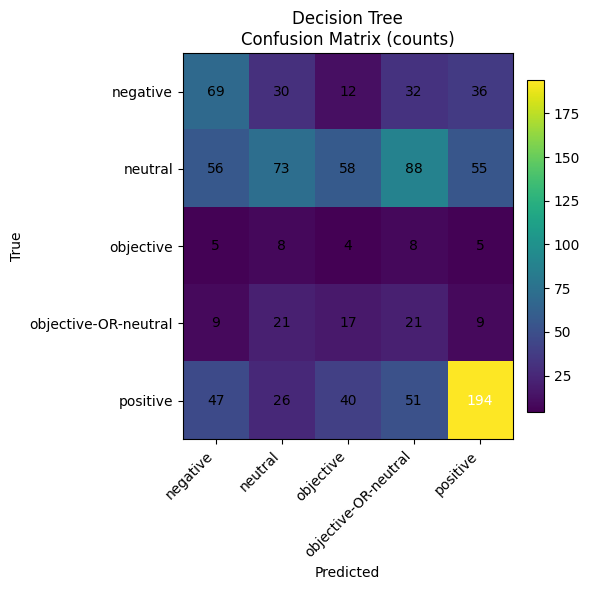

In [11]:
dt = DecisionTreeClassifier(class_weight="balanced", random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
cm = plot_confusion_matrix(y_test, y_pred_dt,
                           class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Decision Tree")


Con el árbol de decisiones vemos que prácticamente no nos sirvió de nada. En lugar de darnos mejoras, este clasificador redujo la exactitud a 37 %, dejando nuestras métricas en un promedio de 35 %, valores que resultan bastante bajos.

Al menos con **Bag of Words** lo que más nos convino fue trabajar con regresión logística.

## One-Hot Encoding
Para One-Hot Encoding estaremos variando los clasificadores para evaluar con qué combinación obtenemos una mejor exactitud.
Los clasificadores que vamos a usar son:

- Naive Bayes
- SVM Lineal
- Regresión Logística
- Árboles de decisión

Estos clasificadores se eligieron porque funcionan bien con representaciones dispersas como las que genera OHE. Naive Bayes y regresión logística son opciones estándar por su eficiencia y su buen rendimiento con vectores binarios de alta dimensionalidad. Los SVM lineales suelen ofrecer alta precisión en espacios muy grandes y dispersos. Los árboles de decisión permiten explorar relaciones no lineales incluso con entradas codificadas de forma binaria sin requerir ingeniería de características adicional.

In [12]:
# --- VECTORIZATION ---
# Fit ONLY on train; transform test with the SAME vectorizer
vectorizer = CountVectorizer(binary=True, token_pattern=r"(?u)\b\w[\w']+\b")
X_train = vectorizer.fit_transform(X_train_texts)   # 2D sparse matrix
X_test  = vectorizer.transform(X_test_texts)        # 2D sparse matrix

### One Hot Encoding - Naive Bayes

Accuracy: 0.40451745379876797
                      precision    recall  f1-score   support

            negative       0.60      0.19      0.29       179
             neutral       0.41      0.10      0.16       330
           objective       0.07      0.10      0.08        30
objective-OR-neutral       0.16      0.17      0.16        77
            positive       0.44      0.87      0.58       358

            accuracy                           0.40       974
           macro avg       0.33      0.29      0.25       974
        weighted avg       0.42      0.40      0.34       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.596     0.190     0.288       179
             neutral      0.410     0.097     0.157       330
           objective      0.067     0.100     0.080        30
objective-OR-neutral      0.157     0.169     0.163        77
            positive      0.439     0.872     0.584       358


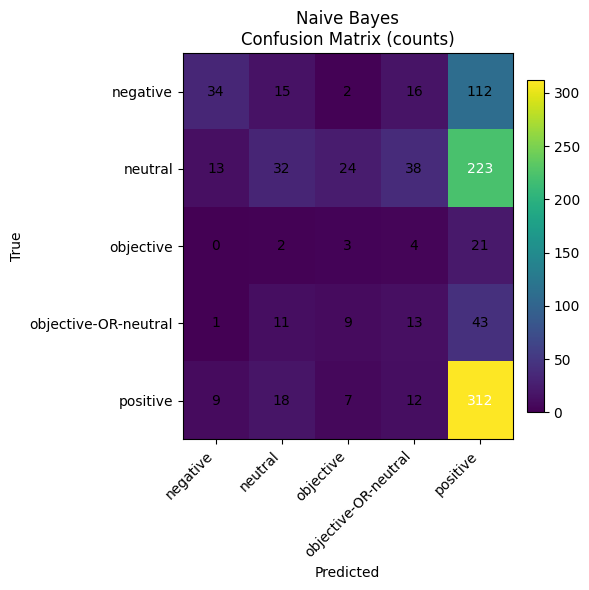

In [13]:
nb = MultinomialNB()
nb.fit(X_train, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                                    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
                                    title_prefix="Naive Bayes")

Naive Bayes con One Hot Encoding parece haber mejorado levemente con respecto a Bag of Words, sin embargo, considero que no vale la pena quedarse con un modelo basado en OHE y Naive Bayes en lugar de uno con Bag of Words utilizando el mismo clasificador. De igual manera, ambos modelos son malos como lo podemos ver en nuestra matriz de confusión, teniendo un sesgo notorio hacia nuestra clase positiva.

### One Hot Encoding - Linear SVC

Accuracy: 0.41786447638603696
                      precision    recall  f1-score   support

            negative       0.49      0.36      0.42       179
             neutral       0.42      0.25      0.31       330
           objective       0.05      0.20      0.08        30
objective-OR-neutral       0.13      0.26      0.17        77
            positive       0.62      0.65      0.64       358

            accuracy                           0.42       974
           macro avg       0.34      0.35      0.32       974
        weighted avg       0.47      0.42      0.43       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.492     0.363     0.418       179
             neutral      0.419     0.252     0.314       330
           objective      0.051     0.200     0.081        30
objective-OR-neutral      0.132     0.260     0.175        77
            positive      0.623     0.651     0.637       358



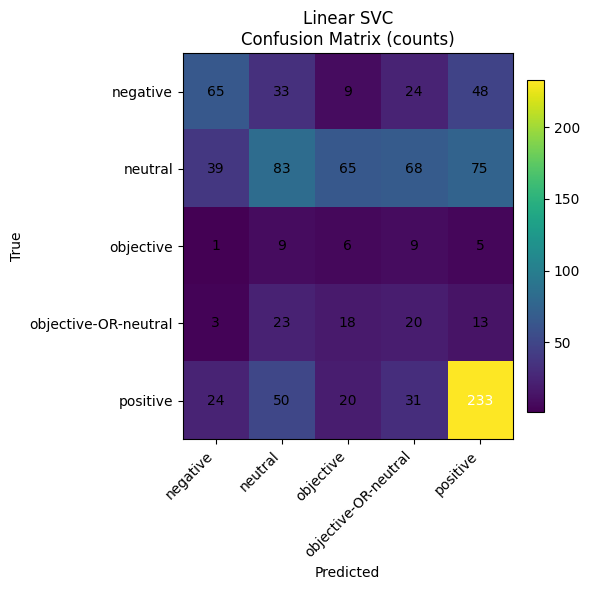

In [14]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                                    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
                                    title_prefix="Linear SVC")


Lo mismo pasó aqui con Linear SVC en donde tenemos una pequeña mejora, pero que igual que en la anterior, considero que no vale la pena mantenernos con estos metodos, teniendo los resultados tan similares a los otros.

### One Hot Encoding - Regresión Logística

Accuracy: 0.41683778234086244
                      precision    recall  f1-score   support

            negative       0.49      0.37      0.42       179
             neutral       0.42      0.26      0.32       330
           objective       0.05      0.23      0.09        30
objective-OR-neutral       0.14      0.29      0.18        77
            positive       0.66      0.63      0.64       358

            accuracy                           0.42       974
           macro avg       0.35      0.36      0.33       974
        weighted avg       0.49      0.42      0.44       974

Logistic Regression — classification report
                      precision    recall  f1-score   support

            negative      0.485     0.369     0.419       179
             neutral      0.422     0.264     0.325       330
           objective      0.053     0.233     0.086        30
objective-OR-neutral      0.137     0.286     0.185        77
            positive      0.663     0.626     0.644   

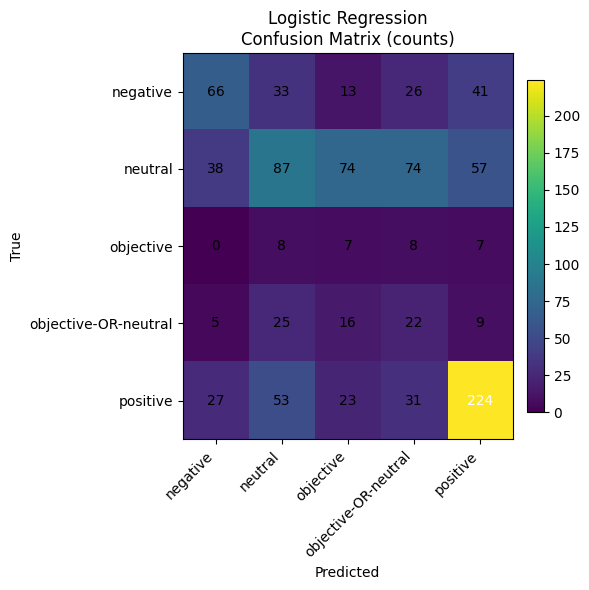

In [15]:
logreg = LogisticRegression(max_iter=10000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
cm = plot_confusion_matrix(y_test, y_pred_lr,
                                    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
                                    title_prefix="Logistic Regression")


Por primera vez vemos que este clasificador no ofrece una mejora en comparación con los anteriores. Además de ser peor que SVC, también rinde peor que el mismo clasificador utilizando Bag of Words. En pocas palabras, esta combinación no valió la pena.

### One Hot Encoding - Árboles de decisión

Accuracy: 0.364476386036961
                      precision    recall  f1-score   support

            negative       0.36      0.35      0.36       179
             neutral       0.41      0.21      0.28       330
           objective       0.06      0.30      0.11        30
objective-OR-neutral       0.11      0.27      0.16        77
            positive       0.63      0.54      0.58       358

            accuracy                           0.36       974
           macro avg       0.32      0.33      0.30       974
        weighted avg       0.45      0.36      0.39       974

Decision Tree (OHE) — classification report
                      precision    recall  f1-score   support

            negative      0.362     0.352     0.357       179
             neutral      0.415     0.206     0.275       330
           objective      0.065     0.300     0.107        30
objective-OR-neutral      0.111     0.273     0.158        77
            positive      0.630     0.542     0.583     

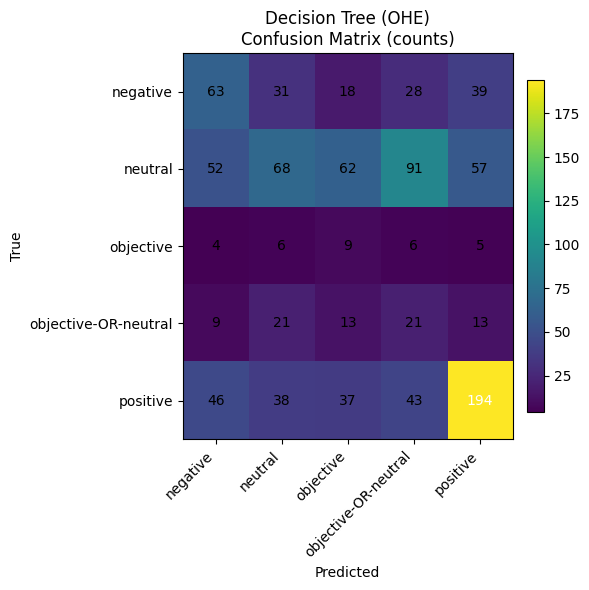

In [16]:
dt = DecisionTreeClassifier(
    class_weight="balanced",
    max_depth=None,
    random_state=0
)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
cm = plot_confusion_matrix(
    y_test, y_pred_dt,
    class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
    title_prefix="Decision Tree (OHE)"
)

Igual que con Bag Of words, este clasificador nuevamente nos dio resultados más bajos que los anteriores, no creo recomendar este combinación para datasets como con el que estamos trabajando.

## TF-IDF

En el caso de TF-IDF, también evaluaremos múltiples clasificadores para determinar cuál se adapta mejor a esta representación basada en la relevancia de los términos. Los modelos elegidos son:


- Naive Bayes
- SVM Lineal
- Regresión Logística
- Árboles de decisión


Estos algoritmos se seleccionan porque han demostrado buen desempeño cuando se trabaja con vectores ponderados como los que produce TF-IDF. Naive Bayes suele ser competitivo en texto gracias a su simpleza y velocidad. Los modelos lineales, como SVM y regresión logística, aprovechan bien las ponderaciones de TF-IDF para establecer fronteras de decisión efectivas en espacios de alta dimensionalidad. Los árboles de decisión permiten examinar patrones no lineales a partir de las puntuaciones TF-IDF sin necesidad de transformaciones adicionales.

Además de la representación estándar TF-IDF, también trabajaremos con sus componentes por separado para observar cómo influye cada uno en el desempeño de los modelos. En total realizaremos 12 evaluaciones: cuatro clasificadores utilizando TF-IDF, cuatro empleando únicamente TF y cuatro usando únicamente IDF. Esta división permite analizar si la frecuencia cruda de los términos, su peso inverso en el corpus o la combinación de ambos aporta mejores resultados según el algoritmo. Al mantener los mismos clasificadores en cada variante —Naive Bayes, SVM lineal, regresión logística y árboles de decisión— podremos comparar de forma directa cómo cambia su rendimiento dependiendo del tipo de representación utilizada.

In [ ]:
# TF-IDF vectorizer (word-level)
# - token_pattern keeps apostrophes inside tokens (e.g., "don't")
# - sublinear_tf=True applies 1 + log(tf), often helps with long-tail terms
tfidf = TfidfVectorizer(
    token_pattern=r"(?u)\b\w[\w']+\b",
    sublinear_tf=True,
    use_idf=True,
)
# Fit on TRAIN only; transform TEST with the same vocabulary
X_train = tfidf.fit_transform(X_train_texts)
X_test  = tfidf.transform(X_test_texts)


In [18]:
tf_vectorizer  = TfidfVectorizer(
    token_pattern=r"(?u)\b\w[\w']+\b",
    ngram_range=(1,1),
    use_idf=False,      # sin IDF
    sublinear_tf=True,  # TF = 1 + log(tf)
    norm=None
)

X_train_tf = tf_vectorizer.fit_transform(X_train_texts)
X_test_tf  = tf_vectorizer.transform(X_test_texts)


In [19]:
bin_vec = CountVectorizer(
    token_pattern=r"(?u)\b\w[\w']+\b",
    ngram_range=(1,1),
    binary=True
)
X_train_bin = bin_vec.fit_transform(X_train_texts)
X_test_bin  = bin_vec.transform(X_test_texts)

idf_only = TfidfTransformer(
    use_idf=True,
    sublinear_tf=False,
    norm=None
)

X_train_idf = idf_only.fit_transform(X_train_bin)
X_test_idf  = idf_only.transform(X_test_bin)


### TF-IDF - Naive Bayes

Accuracy: 0.3726899383983573
                      precision    recall  f1-score   support

            negative       1.00      0.02      0.04       179
             neutral       0.00      0.00      0.00       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.33      0.01      0.03        77
            positive       0.37      1.00      0.54       358

            accuracy                           0.37       974
           macro avg       0.34      0.21      0.12       974
        weighted avg       0.35      0.37      0.21       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      1.000     0.022     0.044       179
             neutral      0.000     0.000     0.000       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.333     0.013     0.025        77
            positive      0.370     1.000     0.540       358



f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\TEC\Septim

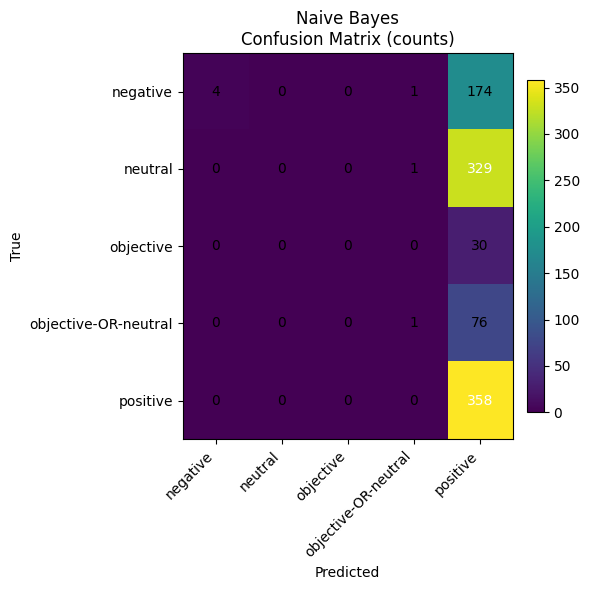

In [20]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

### TF - Naive Bayes

Accuracy: 0.40143737166324434
                      precision    recall  f1-score   support

            negative       0.59      0.19      0.29       179
             neutral       0.43      0.11      0.17       330
           objective       0.07      0.10      0.08        30
objective-OR-neutral       0.15      0.17      0.16        77
            positive       0.44      0.85      0.58       358

            accuracy                           0.40       974
           macro avg       0.33      0.28      0.26       974
        weighted avg       0.43      0.40      0.34       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.586     0.190     0.287       179
             neutral      0.429     0.109     0.174       330
           objective      0.065     0.100     0.079        30
objective-OR-neutral      0.149     0.169     0.159        77
            positive      0.436     0.852     0.577       358


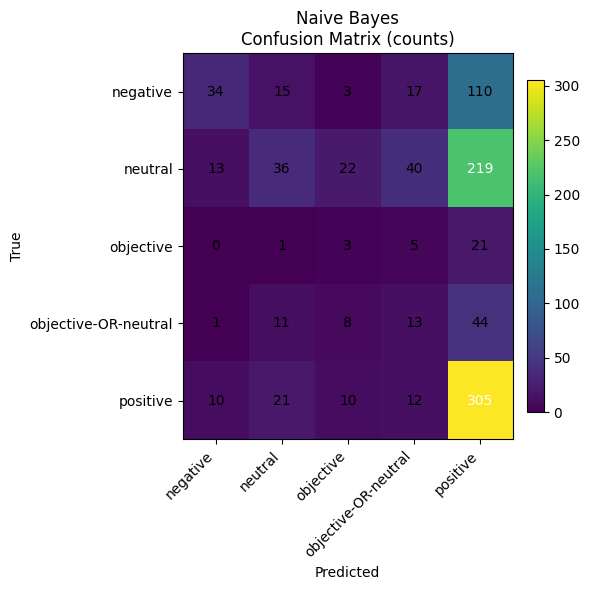

In [21]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train_tf, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test_tf)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

### IDF - Naive Bayes

Accuracy: 0.3459958932238193
                      precision    recall  f1-score   support

            negative       0.38      0.39      0.38       179
             neutral       0.35      0.20      0.26       330
           objective       0.03      0.10      0.05        30
objective-OR-neutral       0.12      0.26      0.16        77
            positive       0.52      0.50      0.51       358

            accuracy                           0.35       974
           macro avg       0.28      0.29      0.27       974
        weighted avg       0.39      0.35      0.36       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.383     0.385     0.384       179
             neutral      0.354     0.203     0.258       330
           objective      0.031     0.100     0.047        30
objective-OR-neutral      0.120     0.260     0.165        77
            positive      0.522     0.497     0.509       358



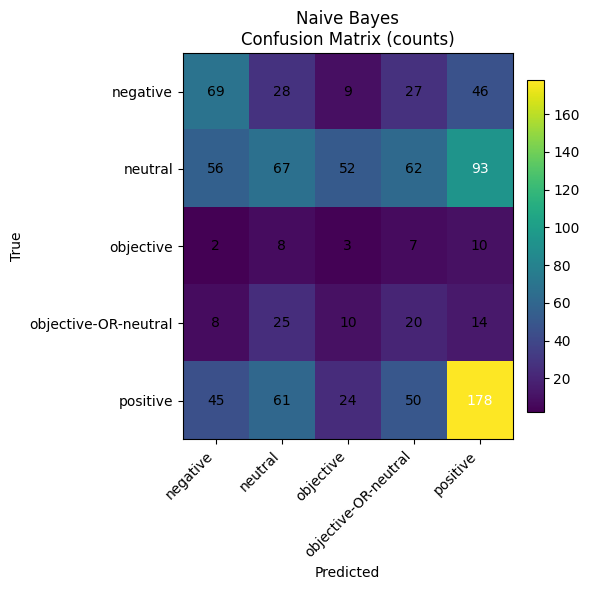

In [22]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train_idf, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test_idf)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

### TF-IDF - Linear SVC

Accuracy: 0.419917864476386
                      precision    recall  f1-score   support

            negative       0.47      0.35      0.40       179
             neutral       0.41      0.25      0.31       330
           objective       0.05      0.20      0.08        30
objective-OR-neutral       0.15      0.29      0.19        77
            positive       0.63      0.66      0.64       358

            accuracy                           0.42       974
           macro avg       0.34      0.35      0.33       974
        weighted avg       0.47      0.42      0.43       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.470     0.352     0.403       179
             neutral      0.411     0.252     0.312       330
           objective      0.053     0.200     0.083        30
objective-OR-neutral      0.147     0.286     0.194        77
            positive      0.628     0.656     0.642       358

  

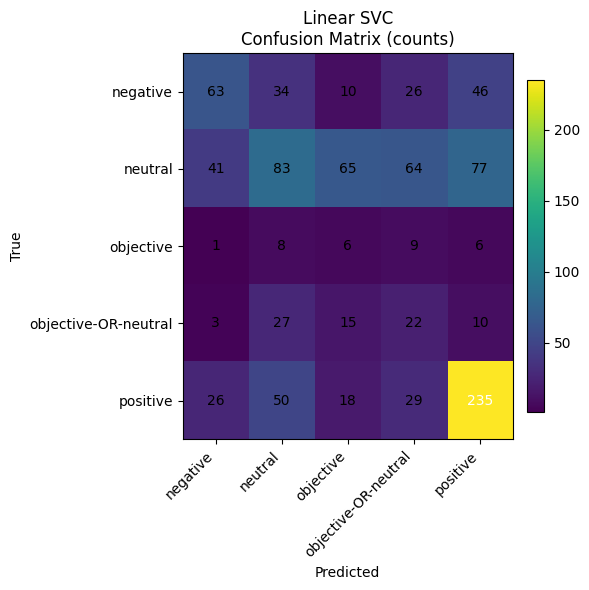

In [23]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

### TF - Linear SVC

Accuracy: 0.41478439425051333
                      precision    recall  f1-score   support

            negative       0.49      0.34      0.40       179
             neutral       0.42      0.26      0.32       330
           objective       0.04      0.13      0.06        30
objective-OR-neutral       0.15      0.32      0.21        77
            positive       0.61      0.64      0.63       358

            accuracy                           0.41       974
           macro avg       0.34      0.34      0.32       974
        weighted avg       0.47      0.41      0.43       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.488     0.341     0.401       179
             neutral      0.417     0.261     0.321       330
           objective      0.037     0.133     0.058        30
objective-OR-neutral      0.153     0.325     0.208        77
            positive      0.615     0.637     0.626       358



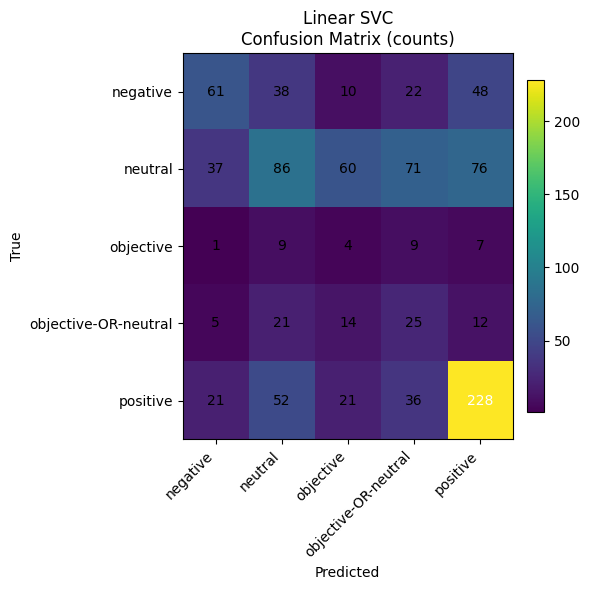

In [24]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_tf, y_train)
y_pred_svm = svm.predict(X_test_tf)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

### IDF - Linear SVC

Accuracy: 0.41786447638603696
                      precision    recall  f1-score   support

            negative       0.49      0.36      0.42       179
             neutral       0.42      0.25      0.31       330
           objective       0.05      0.20      0.08        30
objective-OR-neutral       0.13      0.26      0.17        77
            positive       0.62      0.65      0.64       358

            accuracy                           0.42       974
           macro avg       0.34      0.35      0.32       974
        weighted avg       0.47      0.42      0.43       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.492     0.363     0.418       179
             neutral      0.419     0.252     0.314       330
           objective      0.051     0.200     0.081        30
objective-OR-neutral      0.132     0.260     0.175        77
            positive      0.623     0.651     0.637       358



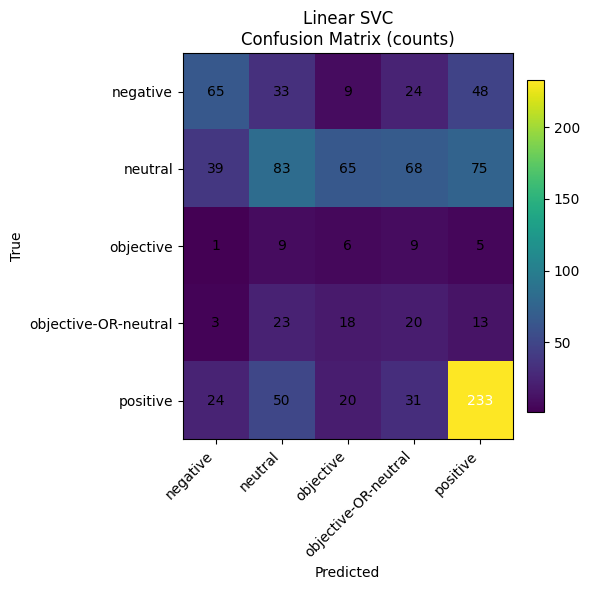

In [25]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_bin, y_train)
y_pred_svm = svm.predict(X_test_bin)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

### TF-IDF - Regresión Logística

Accuracy: 0.41683778234086244
                      precision    recall  f1-score   support

            negative       0.44      0.44      0.44       179
             neutral       0.42      0.26      0.32       330
           objective       0.09      0.40      0.14        30
objective-OR-neutral       0.13      0.23      0.16        77
            positive       0.68      0.59      0.63       358

            accuracy                           0.42       974
           macro avg       0.35      0.39      0.34       974
        weighted avg       0.49      0.42      0.44       974

Logistic Regression — classification report
                      precision    recall  f1-score   support

            negative      0.441     0.441     0.441       179
             neutral      0.424     0.261     0.323       330
           objective      0.085     0.400     0.140        30
objective-OR-neutral      0.127     0.234     0.164        77
            positive      0.683     0.589     0.633   

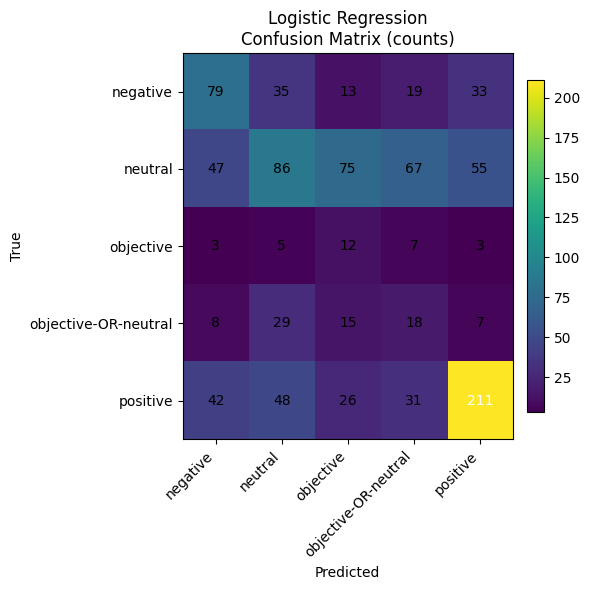

In [26]:
logreg = LogisticRegression(max_iter=10000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
cm = plot_confusion_matrix(y_test, y_pred_lr,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Logistic Regression")

### TF - Regresión Logística

Accuracy: 0.40143737166324434
                      precision    recall  f1-score   support

            negative       0.59      0.19      0.29       179
             neutral       0.43      0.11      0.17       330
           objective       0.07      0.10      0.08        30
objective-OR-neutral       0.15      0.17      0.16        77
            positive       0.44      0.85      0.58       358

            accuracy                           0.40       974
           macro avg       0.33      0.28      0.26       974
        weighted avg       0.43      0.40      0.34       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.586     0.190     0.287       179
             neutral      0.429     0.109     0.174       330
           objective      0.065     0.100     0.079        30
objective-OR-neutral      0.149     0.169     0.159        77
            positive      0.436     0.852     0.577       358


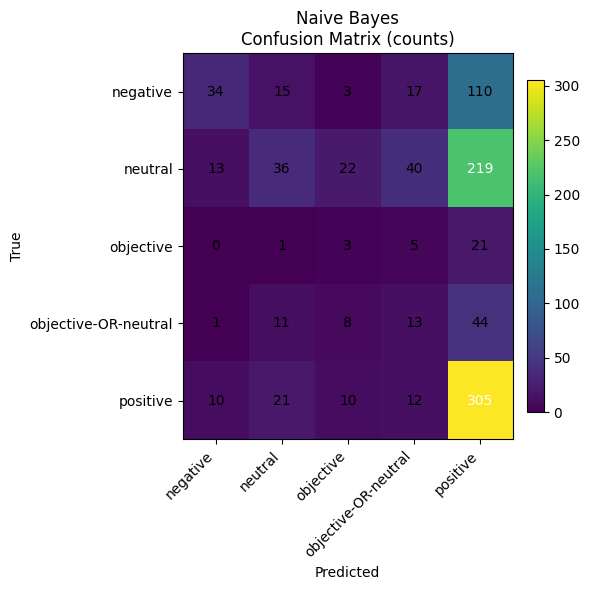

In [27]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train_tf, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test_tf)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

### IDF - Regresión Logística

Accuracy: 0.3459958932238193
                      precision    recall  f1-score   support

            negative       0.38      0.39      0.38       179
             neutral       0.35      0.20      0.26       330
           objective       0.03      0.10      0.05        30
objective-OR-neutral       0.12      0.26      0.16        77
            positive       0.52      0.50      0.51       358

            accuracy                           0.35       974
           macro avg       0.28      0.29      0.27       974
        weighted avg       0.39      0.35      0.36       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.383     0.385     0.384       179
             neutral      0.354     0.203     0.258       330
           objective      0.031     0.100     0.047        30
objective-OR-neutral      0.120     0.260     0.165        77
            positive      0.522     0.497     0.509       358



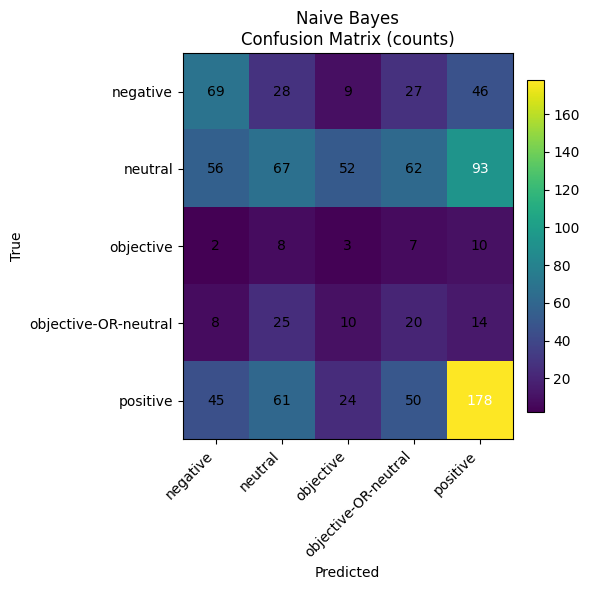

In [28]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train_idf, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test_idf)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

### TF-IDF - Árboles de decisión

Accuracy: 0.37166324435318276
                      precision    recall  f1-score   support

            negative       0.37      0.39      0.38       179
             neutral       0.45      0.26      0.33       330
           objective       0.04      0.17      0.07        30
objective-OR-neutral       0.10      0.22      0.14        77
            positive       0.60      0.51      0.55       358

            accuracy                           0.37       974
           macro avg       0.31      0.31      0.29       974
        weighted avg       0.45      0.37      0.40       974

Decision Tree — classification report
                      precision    recall  f1-score   support

            negative      0.370     0.391     0.380       179
             neutral      0.448     0.264     0.332       330
           objective      0.042     0.167     0.067        30
objective-OR-neutral      0.102     0.221     0.140        77
            positive      0.600     0.511     0.552       35

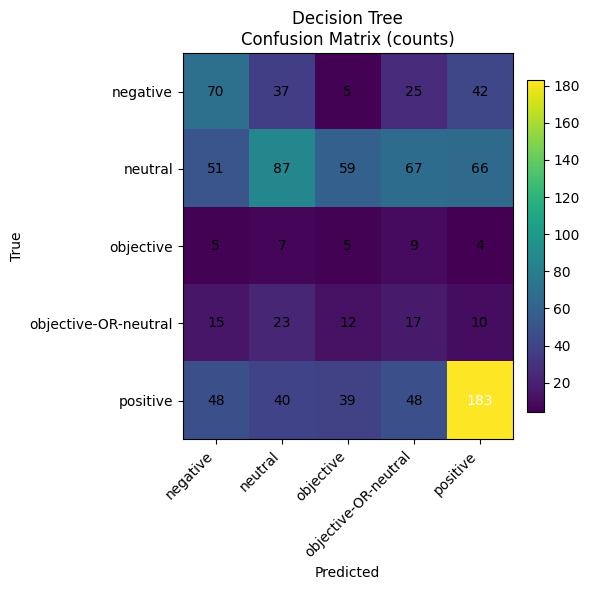

In [29]:
dt = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=0,
    max_depth=None
)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

cm = plot_confusion_matrix(
    y_test,
    y_pred_dt,
    class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
    title_prefix="Decision Tree"
)

### TF - Árboles de decisión

Accuracy: 0.37063655030800824
                      precision    recall  f1-score   support

            negative       0.37      0.39      0.38       179
             neutral       0.46      0.22      0.30       330
           objective       0.03      0.13      0.05        30
objective-OR-neutral       0.11      0.27      0.15        77
            positive       0.65      0.54      0.59       358

            accuracy                           0.37       974
           macro avg       0.32      0.31      0.29       974
        weighted avg       0.47      0.37      0.40       974

Decision Tree — classification report
                      precision    recall  f1-score   support

            negative      0.371     0.385     0.378       179
             neutral      0.462     0.221     0.299       330
           objective      0.031     0.133     0.050        30
objective-OR-neutral      0.106     0.273     0.152        77
            positive      0.647     0.542     0.590       35

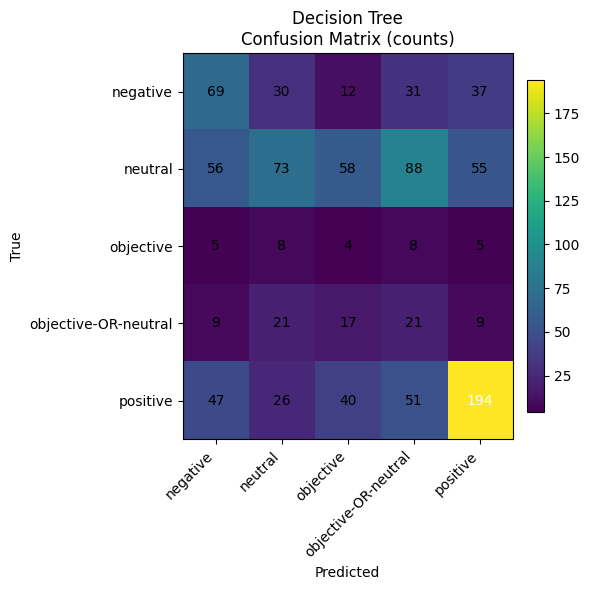

In [30]:
dt = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=0,
    max_depth=None
)

dt.fit(X_train_tf, y_train)
y_pred_dt = dt.predict(X_test_tf)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

cm = plot_confusion_matrix(
    y_test,
    y_pred_dt,
    class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
    title_prefix="Decision Tree"
)

### IDF - Árboles de decisión

Accuracy: 0.364476386036961
                      precision    recall  f1-score   support

            negative       0.36      0.35      0.36       179
             neutral       0.41      0.21      0.28       330
           objective       0.06      0.30      0.11        30
objective-OR-neutral       0.11      0.27      0.16        77
            positive       0.63      0.54      0.58       358

            accuracy                           0.36       974
           macro avg       0.32      0.33      0.30       974
        weighted avg       0.45      0.36      0.39       974

Decision Tree — classification report
                      precision    recall  f1-score   support

            negative      0.362     0.352     0.357       179
             neutral      0.415     0.206     0.275       330
           objective      0.065     0.300     0.107        30
objective-OR-neutral      0.111     0.273     0.158        77
            positive      0.630     0.542     0.583       358


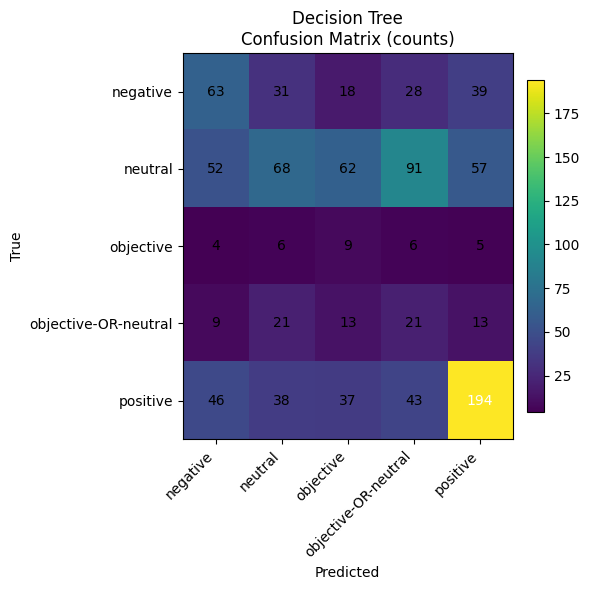

In [31]:
dt = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=0,
    max_depth=None
)

dt.fit(X_train_bin, y_train)
y_pred_dt = dt.predict(X_test_bin)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

cm = plot_confusion_matrix(
    y_test,
    y_pred_dt,
    class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
    title_prefix="Decision Tree"
)

## Modelo de N-gramas (N-grams)

Para la representación basada en N-gramas evaluaremos distintos tamaños de contexto lingüístico, lo que permite capturar patrones secuenciales más amplios que las unidades individuales. En este caso utilizaremos los clasificadores que suelen ofrecer mejor rendimiento cuando se trabaja con vectores de alta dimensionalidad y fuerte dispersión:

- SVM Lineal
- Regresión Logística
- Naive Bayes Multinomial
- Random Forest

Estos modelos son adecuados para N-gramas porque pueden manejar grandes espacios de características generados por combinaciones de palabras. Los SVM lineales y la regresión logística mantienen un buen equilibrio entre rendimiento y eficiencia aun cuando el número de atributos crece rápidamente. Naive Bayes multinomial sigue siendo competitivo en tareas de texto, especialmente cuando se incorporan N-gramas frecuentes. Random Forest se incluye para explorar cómo un conjunto de árboles puede aprovechar interacciones no lineales dentro de secuencias más largas sin necesidad de transformaciones adicionales.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

bigram = CountVectorizer(
    token_pattern=r"(?u)\b\w[\w']+\b",
    ngram_range=(2, 2)
)

X_train_bigram = bigram.fit_transform(X_train_texts)
X_test_bigram  = bigram.transform(X_test_texts)

trigram = CountVectorizer(
    token_pattern=r"(?u)\b\w[\w']+\b",
    ngram_range=(3, 3)
)

X_train_trigram = trigram.fit_transform(X_train_texts)
X_test_trigram  = trigram.transform(X_test_texts)

range_gram = CountVectorizer(
    token_pattern=r"(?u)\b\w[\w']+\b",
    ngram_range=(2, 2)
)

X_train_range_gram = range_gram.fit_transform(X_train_texts)
X_test_range_gram  = range_gram.transform(X_test_texts)

### N-grams - SVM Lineal

Accuracy: 0.37063655030800824
                      precision    recall  f1-score   support

            negative       0.49      0.19      0.27       179
             neutral       0.36      0.08      0.14       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.10      0.09      0.10        77
            positive       0.41      0.82      0.54       358

            accuracy                           0.37       974
           macro avg       0.27      0.24      0.21       974
        weighted avg       0.37      0.37      0.30       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.493     0.190     0.274       179
             neutral      0.359     0.085     0.137       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.101     0.091     0.096        77
            positive      0.406     0.816     0.542       358



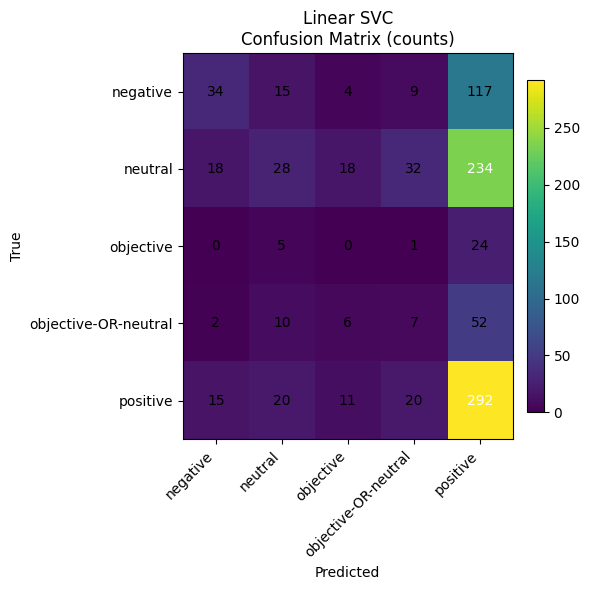

In [33]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_bigram, y_train)
y_pred_svm = svm.predict(X_test_bigram)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

Accuracy: 0.37063655030800824
                      precision    recall  f1-score   support

            negative       0.43      0.02      0.03       179
             neutral       0.29      0.01      0.01       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.38      0.99      0.54       358

            accuracy                           0.37       974
           macro avg       0.22      0.20      0.12       974
        weighted avg       0.31      0.37      0.21       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.429     0.017     0.032       179
             neutral      0.286     0.006     0.012       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.375     0.994     0.545       358



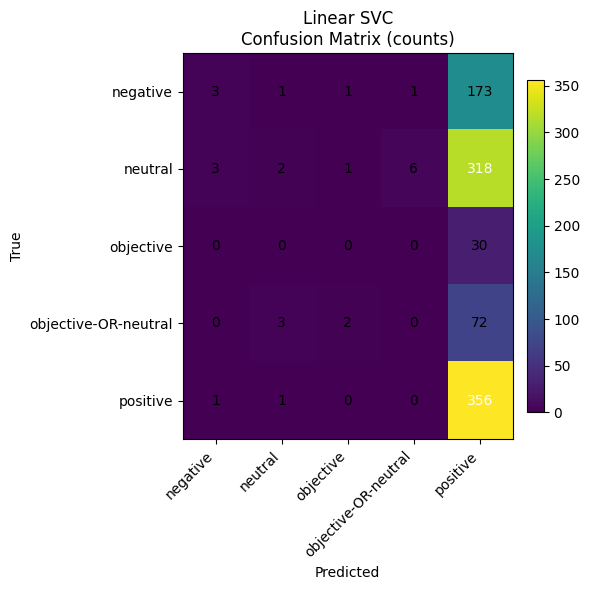

In [34]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_trigram, y_train)
y_pred_svm = svm.predict(X_test_trigram)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

Accuracy: 0.37063655030800824
                      precision    recall  f1-score   support

            negative       0.49      0.19      0.27       179
             neutral       0.36      0.08      0.14       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.10      0.09      0.10        77
            positive       0.41      0.82      0.54       358

            accuracy                           0.37       974
           macro avg       0.27      0.24      0.21       974
        weighted avg       0.37      0.37      0.30       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.493     0.190     0.274       179
             neutral      0.359     0.085     0.137       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.101     0.091     0.096        77
            positive      0.406     0.816     0.542       358



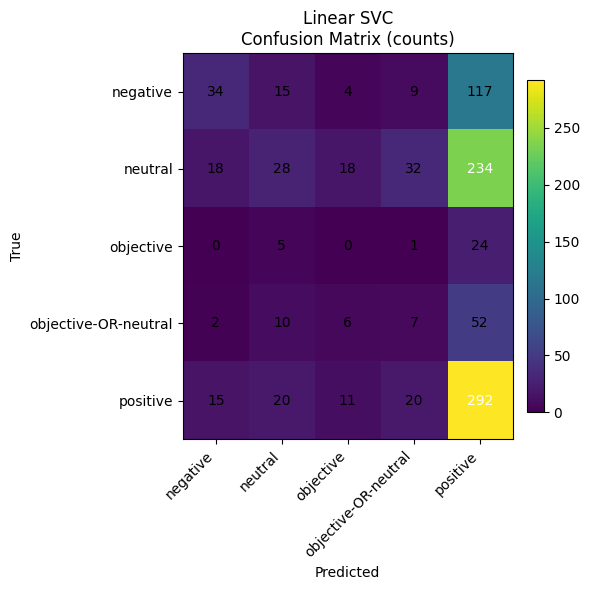

In [35]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_range_gram, y_train)
y_pred_svm = svm.predict(X_test_range_gram)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

### N-grams - Regresión Logística

Accuracy: 0.37166324435318276
                      precision    recall  f1-score   support

            negative       0.47      0.16      0.24       179
             neutral       0.38      0.09      0.15       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.11      0.08      0.09        77
            positive       0.40      0.83      0.54       358

            accuracy                           0.37       974
           macro avg       0.27      0.23      0.20       974
        weighted avg       0.37      0.37      0.30       974

Logistic Regression (TF-IDF N-grams) — classification report
                      precision    recall  f1-score   support

            negative      0.475     0.156     0.235       179
             neutral      0.375     0.091     0.146       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.111     0.078     0.092        77
            positive      0.398     0

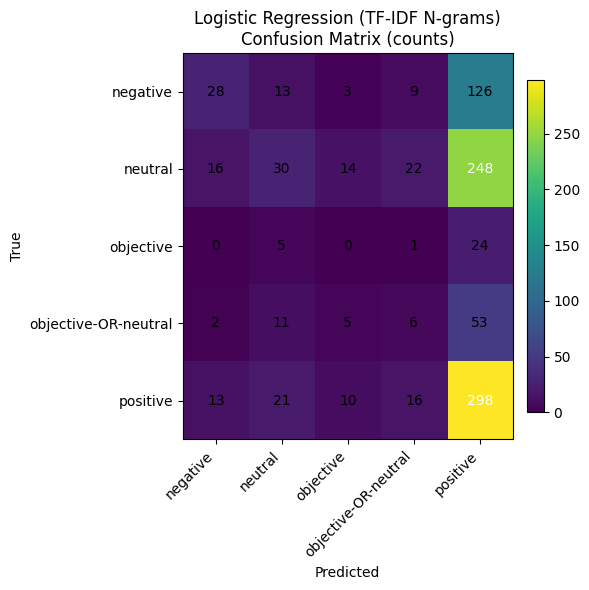

In [36]:
logreg = LogisticRegression(max_iter=10000, class_weight="balanced")
logreg.fit(X_train_bigram, y_train)
y_pred_lr = logreg.predict(X_test_bigram)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
cm = plot_confusion_matrix(
    y_test, y_pred_lr,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="Logistic Regression (TF-IDF N-grams)"
)


Accuracy: 0.36960985626283366
                      precision    recall  f1-score   support

            negative       0.25      0.01      0.01       179
             neutral       0.50      0.01      0.01       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.37      1.00      0.54       358

            accuracy                           0.37       974
           macro avg       0.22      0.20      0.11       974
        weighted avg       0.35      0.37      0.21       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.250     0.006     0.011       179
             neutral      0.500     0.006     0.012       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.372     0.997     0.542       358



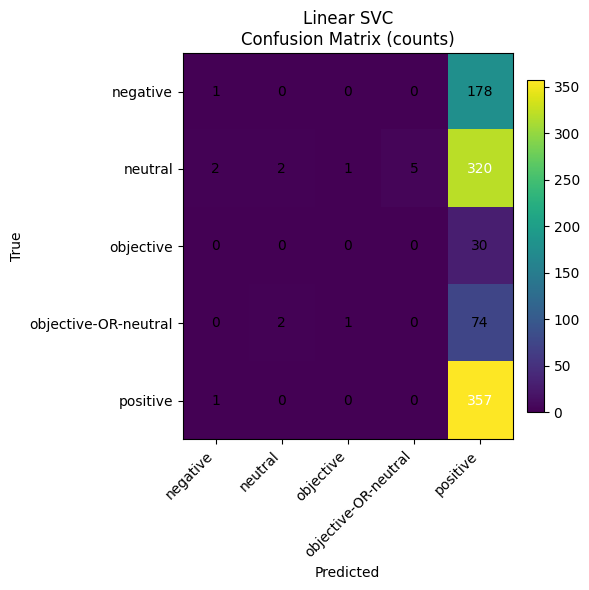

In [37]:
svm = LogisticRegression(class_weight="balanced")
svm.fit(X_train_trigram, y_train)
y_pred_svm = svm.predict(X_test_trigram)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

Accuracy: 0.37166324435318276
                      precision    recall  f1-score   support

            negative       0.47      0.16      0.24       179
             neutral       0.38      0.09      0.15       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.11      0.08      0.09        77
            positive       0.40      0.83      0.54       358

            accuracy                           0.37       974
           macro avg       0.27      0.23      0.20       974
        weighted avg       0.37      0.37      0.30       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.475     0.156     0.235       179
             neutral      0.375     0.091     0.146       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.111     0.078     0.092        77
            positive      0.398     0.832     0.538       358



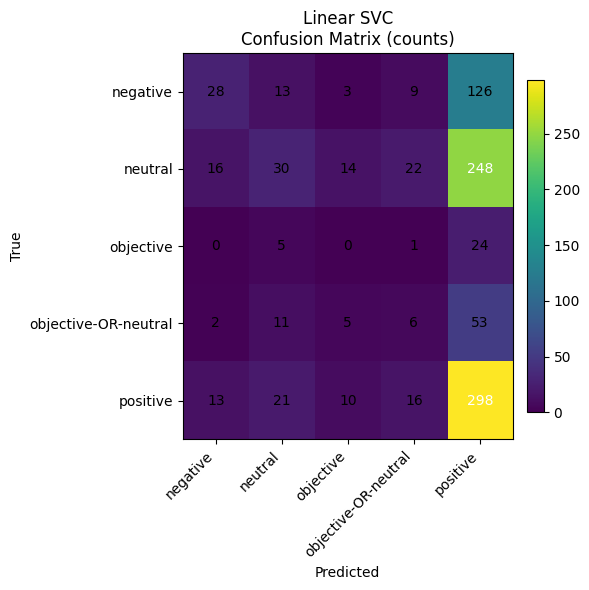

In [38]:
svm = LogisticRegression(class_weight="balanced")
svm.fit(X_train_range_gram, y_train)
y_pred_svm = svm.predict(X_test_range_gram)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

### N-grams - Naive Bayes Multinomial

Accuracy: 0.35523613963039014
                      precision    recall  f1-score   support

            negative       0.45      0.07      0.12       179
             neutral       0.35      0.10      0.16       330
           objective       0.03      0.03      0.03        30
objective-OR-neutral       0.08      0.08      0.08        77
            positive       0.40      0.82      0.53       358

            accuracy                           0.36       974
           macro avg       0.26      0.22      0.18       974
        weighted avg       0.36      0.36      0.28       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.448     0.073     0.125       179
             neutral      0.355     0.100     0.156       330
           objective      0.027     0.033     0.030        30
objective-OR-neutral      0.080     0.078     0.079        77
            positive      0.396     0.818     0.534       358


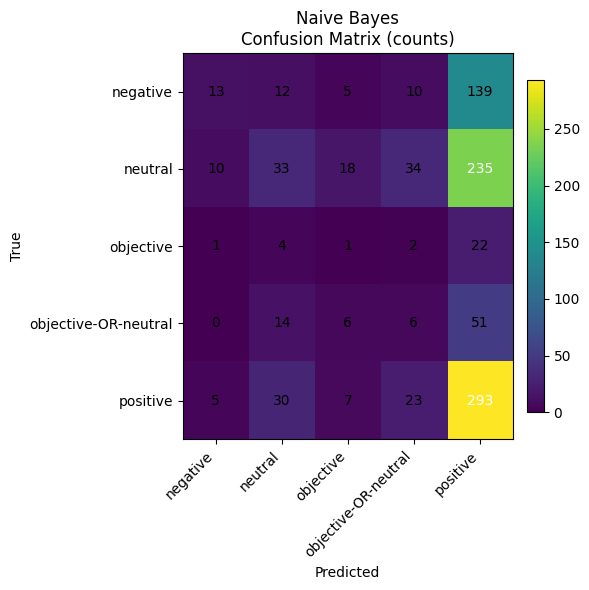

In [39]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train_bigram, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test_bigram)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

Accuracy: 0.364476386036961
                      precision    recall  f1-score   support

            negative       0.33      0.01      0.02       179
             neutral       0.33      0.02      0.04       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.37      0.97      0.54       358

            accuracy                           0.36       974
           macro avg       0.21      0.20      0.12       974
        weighted avg       0.31      0.36      0.22       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.333     0.011     0.022       179
             neutral      0.333     0.021     0.040       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.374     0.966     0.539       358

 

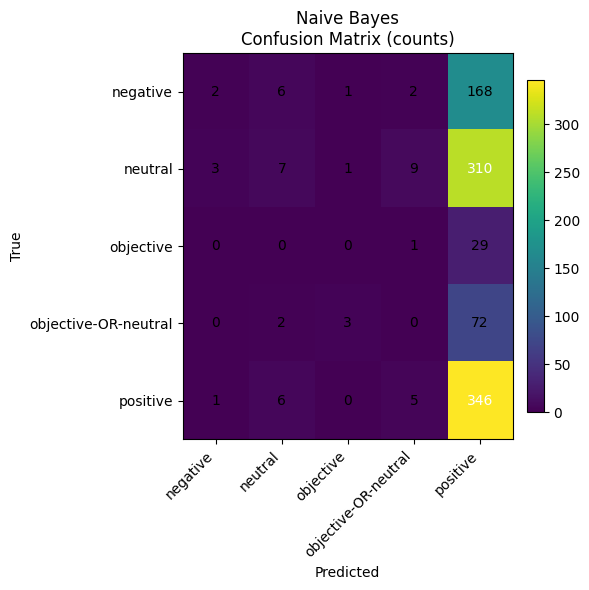

In [40]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train_trigram, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test_trigram)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

Accuracy: 0.35523613963039014
                      precision    recall  f1-score   support

            negative       0.45      0.07      0.12       179
             neutral       0.35      0.10      0.16       330
           objective       0.03      0.03      0.03        30
objective-OR-neutral       0.08      0.08      0.08        77
            positive       0.40      0.82      0.53       358

            accuracy                           0.36       974
           macro avg       0.26      0.22      0.18       974
        weighted avg       0.36      0.36      0.28       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.448     0.073     0.125       179
             neutral      0.355     0.100     0.156       330
           objective      0.027     0.033     0.030        30
objective-OR-neutral      0.080     0.078     0.079        77
            positive      0.396     0.818     0.534       358


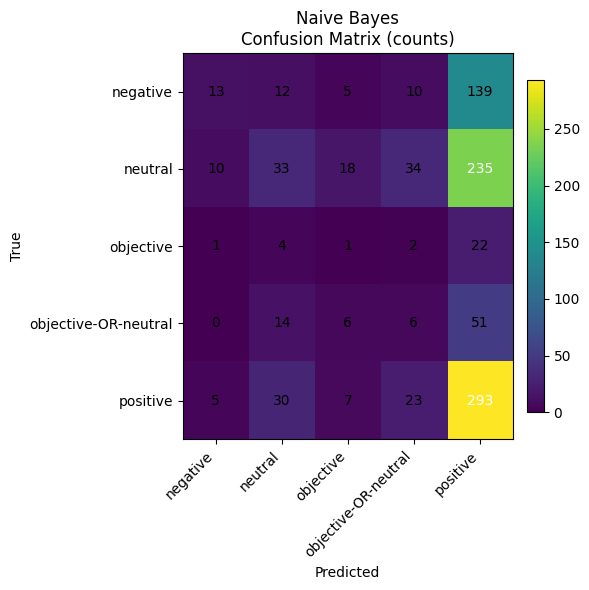

In [41]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train_range_gram, y_train)                # train with labels, not X_test

y_pred = nb.predict(X_test_range_gram)             # predict on test matrix

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

### N-grams - Random Forest

Accuracy: 0.25564681724845995
                      precision    recall  f1-score   support

            negative       0.18      0.68      0.29       179
             neutral       0.41      0.02      0.04       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.44      0.34      0.38       358

            accuracy                           0.26       974
           macro avg       0.21      0.21      0.14       974
        weighted avg       0.33      0.26      0.21       974

Random Forest — classification report
                      precision    recall  f1-score   support

            negative      0.182     0.676     0.287       179
             neutral      0.412     0.021     0.040       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.438     0.338     0.382       35

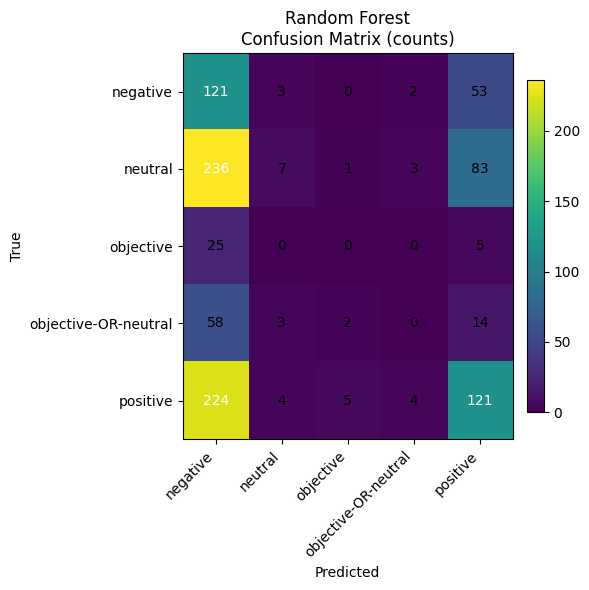

In [42]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    max_depth=None,
    n_jobs=-1,
    random_state=0
)

rf.fit(X_train_bigram, y_train)
y_pred_rf = rf.predict(X_test_bigram)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm = plot_confusion_matrix(
    y_test, y_pred_rf,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="Random Forest"
)

Accuracy: 0.20431211498973306
                      precision    recall  f1-score   support

            negative       0.19      0.98      0.32       179
             neutral       0.67      0.01      0.01       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.62      0.06      0.11       358

            accuracy                           0.20       974
           macro avg       0.29      0.21      0.09       974
        weighted avg       0.49      0.20      0.10       974

Random Forest — classification report
                      precision    recall  f1-score   support

            negative      0.189     0.983     0.317       179
             neutral      0.667     0.006     0.012       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.618     0.059     0.107       35

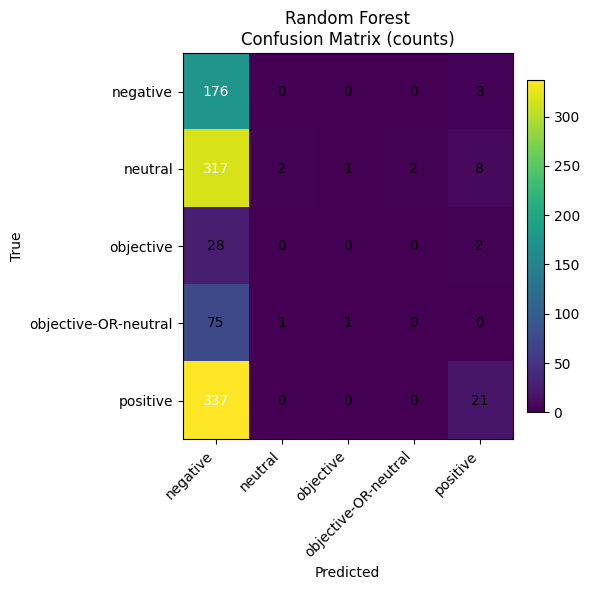

In [43]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    max_depth=None,
    n_jobs=-1,
    random_state=0
)

rf.fit(X_train_trigram, y_train)
y_pred_rf = rf.predict(X_test_trigram)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm = plot_confusion_matrix(
    y_test, y_pred_rf,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="Random Forest"
)

Accuracy: 0.25564681724845995
                      precision    recall  f1-score   support

            negative       0.18      0.68      0.29       179
             neutral       0.41      0.02      0.04       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.44      0.34      0.38       358

            accuracy                           0.26       974
           macro avg       0.21      0.21      0.14       974
        weighted avg       0.33      0.26      0.21       974

Random Forest — classification report
                      precision    recall  f1-score   support

            negative      0.182     0.676     0.287       179
             neutral      0.412     0.021     0.040       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.438     0.338     0.382       35

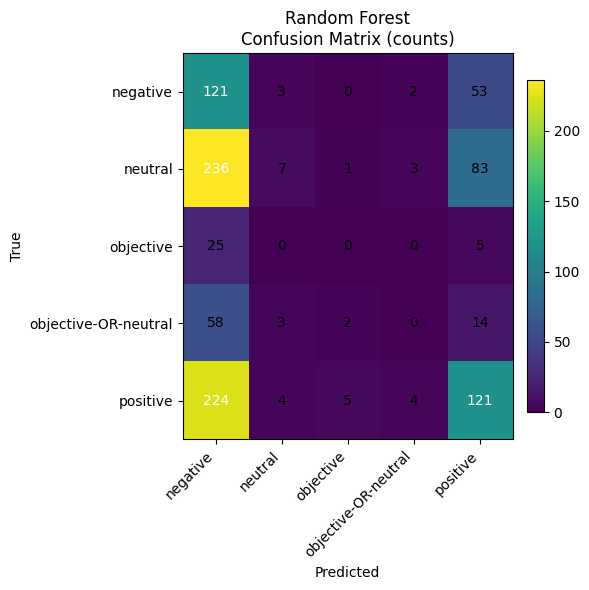

In [44]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    max_depth=None,
    n_jobs=-1,
    random_state=0
)

rf.fit(X_train_range_gram, y_train)
y_pred_rf = rf.predict(X_test_range_gram)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm = plot_confusion_matrix(
    y_test, y_pred_rf,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="Random Forest"
)

## Modelo de Skip-gramas (Skip-grams)

En el caso de los skip-gramas, trabajaremos con patrones que permiten saltar palabras intermedias para capturar relaciones léxicas más flexibles que las que ofrecen los N-gramas tradicionales. Esta representación genera espacios de características aún más amplios, por lo que emplearemos modelos capaces de manejar alta dimensionalidad y variabilidad en las combinaciones:

- SVM Lineal
- Regresión Logística
- Naive Bayes Multinomial
- Gradient Boosting

Los SVM lineales y la regresión logística suelen funcionar bien con vectores dispersos derivados de saltos variables entre términos. Naive Bayes multinomial sigue siendo eficiente cuando los skip-gramas frecuentes aportan señal útil para la clasificación. Gradient Boosting se incorpora para examinar cómo modelos basados en ensambles pueden capturar interacciones más complejas generadas por las combinaciones no contiguas que caracterizan a los skip-gramas.

In [45]:
def skipgram_analyzer(text, max_skip=2):
    # tokens parecidos a tu token_pattern
    tokens = re.findall(r"\b\w[\w']+\b", text.lower())

    for i, w1 in enumerate(tokens):
        # saltos de 1 hasta max_skip
        for skip in range(1, max_skip + 1):
            j = i + skip
            if j < len(tokens):
                w2 = tokens[j]
                yield f"{w1}_{w2}"   # representación del skip-gram

skip_tfidf = TfidfVectorizer(
    analyzer=lambda doc: list(skipgram_analyzer(doc, max_skip=2)),
    sublinear_tf=True,
    use_idf=True,
    norm=None
)

X_train = skip_tfidf.fit_transform(X_train_texts)
X_test  = skip_tfidf.transform(X_test_texts)


### Skip-grams - SVM Lineal

Accuracy: 0.26899383983572894
                      precision    recall  f1-score   support

            negative       0.20      0.84      0.32       179
             neutral       0.41      0.02      0.04       330
           objective       0.00      0.00      0.00        30
objective-OR-neutral       0.00      0.00      0.00        77
            positive       0.58      0.29      0.39       358

            accuracy                           0.27       974
           macro avg       0.24      0.23      0.15       974
        weighted avg       0.39      0.27      0.22       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.199     0.838     0.322       179
             neutral      0.412     0.021     0.040       330
           objective      0.000     0.000     0.000        30
objective-OR-neutral      0.000     0.000     0.000        77
            positive      0.583     0.293     0.390       358



f:\TEC\Septimo\TC3007C\gpuenv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


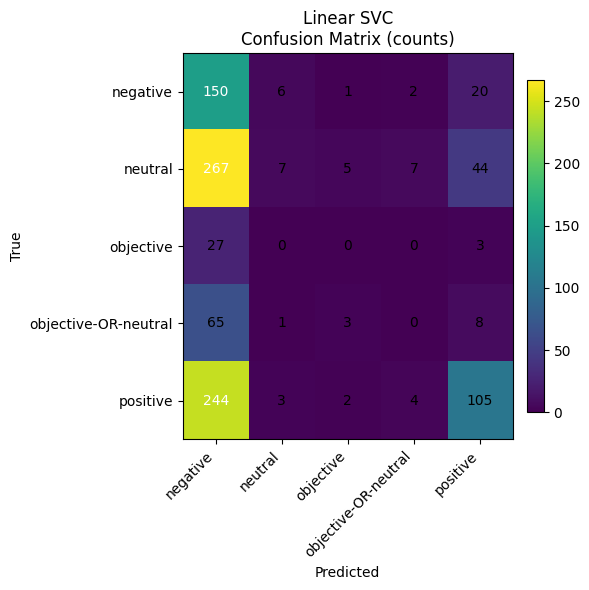

In [46]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

### Skip-grams - Regresión Logística

Accuracy: 0.38295687885010266
                      precision    recall  f1-score   support

            negative       0.46      0.12      0.19       179
             neutral       0.43      0.07      0.12       330
           objective       0.05      0.03      0.04        30
objective-OR-neutral       0.05      0.03      0.04        77
            positive       0.40      0.91      0.55       358

            accuracy                           0.38       974
           macro avg       0.28      0.23      0.19       974
        weighted avg       0.38      0.38      0.28       974

Logistic Regression (Skip-grams) — classification report
                      precision    recall  f1-score   support

            negative      0.458     0.123     0.194       179
             neutral      0.426     0.070     0.120       330
           objective      0.048     0.033     0.039        30
objective-OR-neutral      0.054     0.026     0.035        77
            positive      0.399     0.908

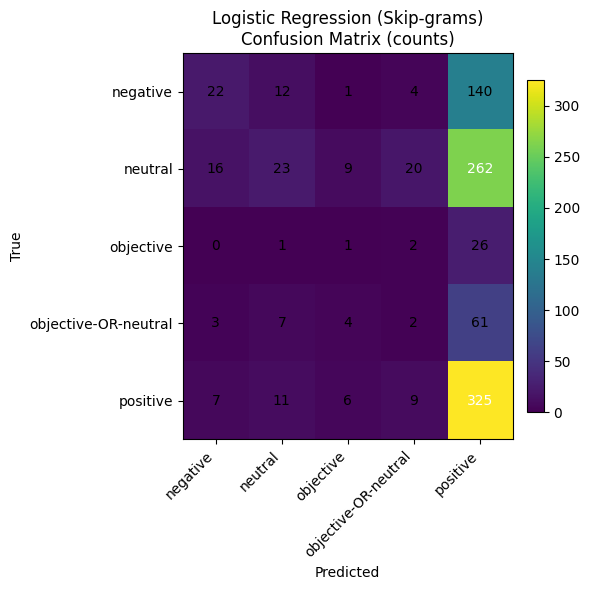

In [47]:
logreg = LogisticRegression(max_iter=10000, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
cm = plot_confusion_matrix(
    y_test, y_pred_lr,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="Logistic Regression (Skip-grams)"
)



### Skip-grams - Naive Bayes Multinomial

Accuracy: 0.34188911704312114
                      precision    recall  f1-score   support

            negative       0.36      0.31      0.33       179
             neutral       0.34      0.18      0.23       330
           objective       0.05      0.20      0.08        30
objective-OR-neutral       0.07      0.09      0.08        77
            positive       0.49      0.57      0.53       358

            accuracy                           0.34       974
           macro avg       0.26      0.27      0.25       974
        weighted avg       0.37      0.34      0.34       974

Naive Bayes — classification report
                      precision    recall  f1-score   support

            negative      0.359     0.313     0.334       179
             neutral      0.335     0.179     0.233       330
           objective      0.052     0.200     0.082        30
objective-OR-neutral      0.067     0.091     0.077        77
            positive      0.487     0.573     0.526       358


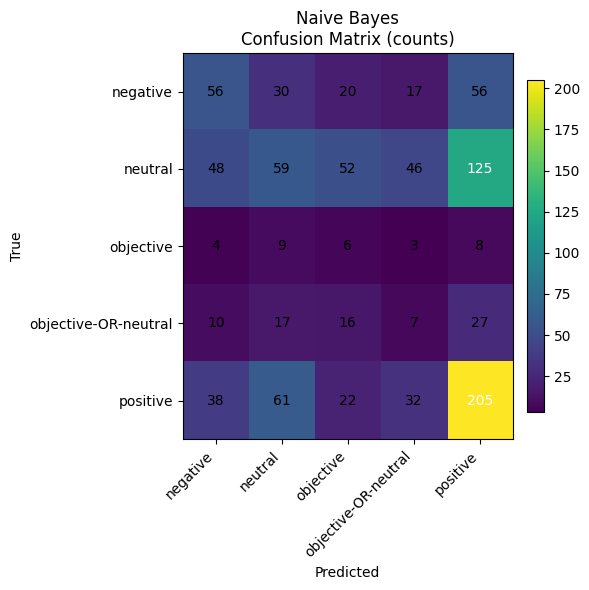

In [48]:
# --- MODEL ---
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Después de entrenar y obtener y_pred:
cm = plot_confusion_matrix(y_test, y_pred,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Naive Bayes")

### Skip-grams - Gradient Boosting

Accuracy: 0.3675564681724846
                      precision    recall  f1-score   support

            negative       0.33      0.01      0.01       179
             neutral       0.44      0.02      0.05       330
           objective       0.12      0.03      0.05        30
objective-OR-neutral       0.25      0.01      0.02        77
            positive       0.37      0.97      0.53       358

            accuracy                           0.37       974
           macro avg       0.30      0.21      0.13       974
        weighted avg       0.37      0.37      0.22       974

Gradient Boosting — classification report
                      precision    recall  f1-score   support

            negative      0.333     0.006     0.011       179
             neutral      0.444     0.024     0.046       330
           objective      0.125     0.033     0.053        30
objective-OR-neutral      0.250     0.013     0.025        77
            positive      0.369     0.969     0.534      

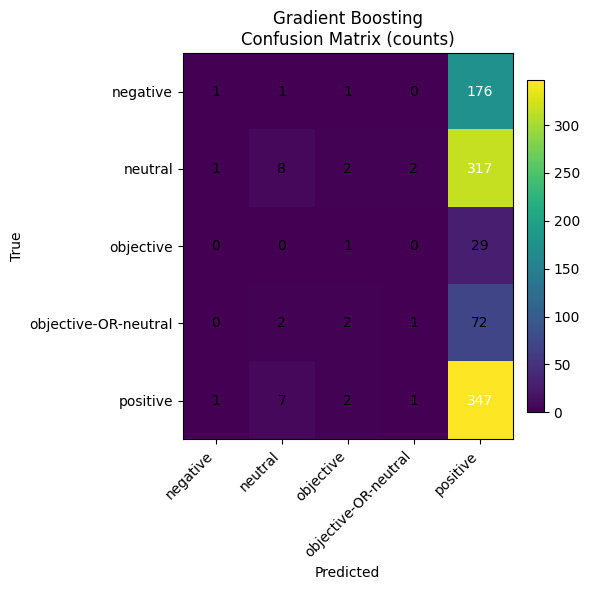

In [49]:
# --- MODEL ---
gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=0
)

gb.fit(X_train.toarray(), y_train)
y_pred_gb = gb.predict(X_test.toarray())

print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

cm = plot_confusion_matrix(
    y_test, y_pred_gb,
    class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
    title_prefix="Gradient Boosting"
)

## Word Embeddings

Para trabajar con representaciones densas y semánticamente más ricas, utilizaremos modelos basados en word embeddings, evaluando tanto embeddings generados desde cero como embeddings provenientes de modelos preentrenados. Este enfoque permite capturar relaciones contextuales entre palabras que no se reflejan en métodos basados únicamente en frecuencias o patrones superficiales.

**Creando el propio modelo de embeddings**

Cuando se entrena un modelo de embeddings desde cero, las representaciones se ajustan específicamente al dominio del conjunto de datos. Esto puede capturar matices particulares del lenguaje del corpus, aunque requiere una cantidad considerable de datos para lograr vectores de buena calidad. En esta etapa los clasificadores más adecuados son:

- Logistic Regression
- SVM Lineal
- Random Forest

Los embeddings densos permiten que modelos lineales y MLP aprovechen relaciones semánticas entre palabras. Random Forest se incluye para observar cómo los árboles manejan estas representaciones compactas, aunque normalmente los modelos lineales y las redes tienen ventaja en este formato.

In [54]:
def tokenize(text):
    # similar a tu token_pattern
    return re.findall(r"\b\w[\w']+\b", text.lower())

X_train_tokens = [tokenize(doc) for doc in X_train_texts]
X_test_tokens  = [tokenize(doc) for doc in X_test_texts]

w2v_model = Word2Vec(
    sentences=X_train_tokens,  # solo train
    vector_size=100,           # dimensión del embedding
    window=5,                  # contexto
    min_count=2,               # ignora palabras muy raras
    workers=4,                 # núcleos
    sg=1,                      # 1 = skip-gram, 0 = CBOW
    epochs=10
)

def doc_to_vec(tokens, model, vector_size):
    # promedia los vectores de las palabras que están en el vocabulario
    vecs = []
    for tok in tokens:
        if tok in model.wv:
            vecs.append(model.wv[tok])
    if len(vecs) == 0:
        return np.zeros(vector_size, dtype="float32")
    else:
        return np.mean(vecs, axis=0)

vector_size = w2v_model.vector_size

X_train_w2v = np.vstack([doc_to_vec(tokens, w2v_model, vector_size)
                         for tokens in X_train_tokens])
X_test_w2v  = np.vstack([doc_to_vec(tokens, w2v_model, vector_size)
                         for tokens in X_test_tokens])


Accuracy: 0.35831622176591377
                      precision    recall  f1-score   support

            negative       0.37      0.59      0.45       179
             neutral       0.45      0.15      0.22       330
           objective       0.06      0.33      0.10        30
objective-OR-neutral       0.11      0.17      0.13        77
            positive       0.61      0.48      0.54       358

            accuracy                           0.36       974
           macro avg       0.32      0.34      0.29       974
        weighted avg       0.45      0.36      0.37       974

Logistic Regression (Word2Vec propio) — classification report
                      precision    recall  f1-score   support

            negative      0.368     0.587     0.453       179
             neutral      0.450     0.148     0.223       330
           objective      0.056     0.333     0.095        30
objective-OR-neutral      0.110     0.169     0.133        77
            positive      0.610     

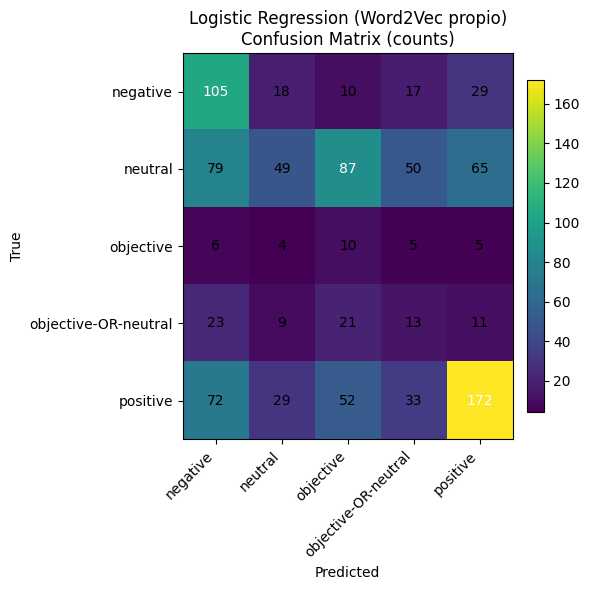

In [61]:
logreg = LogisticRegression(
    max_iter=10000,
    class_weight="balanced"
)

logreg.fit(X_train_w2v, y_train)
y_pred_lr = logreg.predict(X_test_w2v)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

cm = plot_confusion_matrix(
    y_test, y_pred_lr,
    class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
    title_prefix="Logistic Regression (Word2Vec propio)"
)


Accuracy: 0.39835728952772076
                      precision    recall  f1-score   support

            negative       0.40      0.53      0.45       179
             neutral       0.52      0.14      0.22       330
           objective       0.07      0.43      0.13        30
objective-OR-neutral       0.11      0.12      0.11        77
            positive       0.58      0.63      0.60       358

            accuracy                           0.40       974
           macro avg       0.34      0.37      0.30       974
        weighted avg       0.47      0.40      0.39       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.397     0.525     0.452       179
             neutral      0.523     0.139     0.220       330
           objective      0.074     0.433     0.126        30
objective-OR-neutral      0.111     0.117     0.114        77
            positive      0.577     0.631     0.603       358



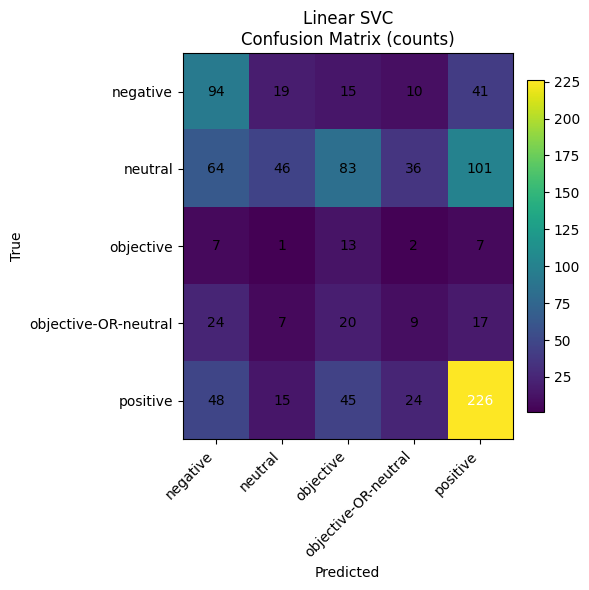

In [60]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_w2v, y_train)
y_pred_svm = svm.predict(X_test_w2v)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

Accuracy: 0.35523613963039014
                      precision    recall  f1-score   support

            negative       0.43      0.16      0.23       179
             neutral       0.33      0.05      0.08       330
           objective       0.03      0.07      0.04        30
objective-OR-neutral       0.08      0.10      0.09        77
            positive       0.42      0.82      0.56       358

            accuracy                           0.36       974
           macro avg       0.26      0.24      0.20       974
        weighted avg       0.35      0.36      0.28       974

Random Forest — classification report
                      precision    recall  f1-score   support

            negative      0.431     0.156     0.230       179
             neutral      0.327     0.048     0.084       330
           objective      0.029     0.067     0.041        30
objective-OR-neutral      0.080     0.104     0.090        77
            positive      0.422     0.816     0.556       35

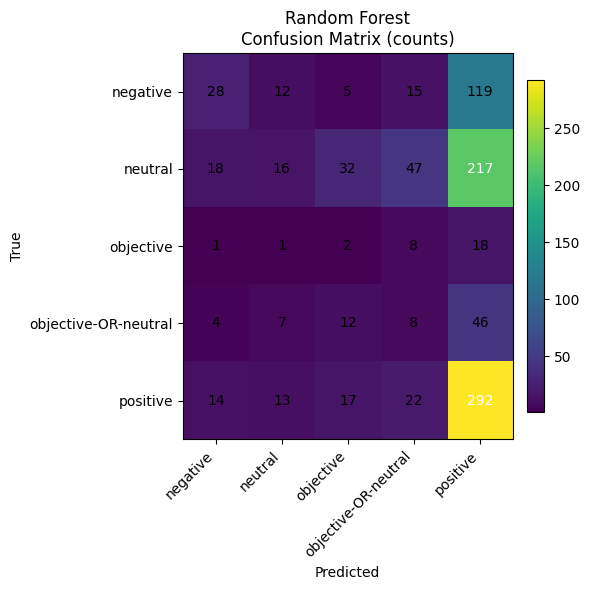

In [58]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    max_depth=None,
    n_jobs=-1,
    random_state=0
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm = plot_confusion_matrix(
    y_test, y_pred_rf,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="Random Forest"
)

**Usando un modelo pre-entrenado**

También realizaremos pruebas utilizando embeddings preentrenados usando Word2Vec. Este modelo entrenado con grandes corpus, proporciona vectores con información semántica más general que puede mejorar el rendimiento incluso en datasets pequeños o medianos. Para este escenario emplearemos los mismos clasificadores, ya que los embeddings preentrenados también generan vectores densos adecuados para modelos lineales y redes:

- Logistic Regression
- SVM Lineal
- Random Forest

Este enfoque permitirá comparar si las representaciones generadas específicamente para nuestro corpus superan o no a los embeddings ampliamente entrenados en datos

In [84]:
w2v_pre_file = os.path.join(
    base_path,
    'glove.6B',
    'glove.6B.100d.txt'
)

w2v_pre = KeyedVectors.load_word2vec_format(
    w2v_pre_file,
    binary=False,
    no_header=True
)

def tokenize(text):
    return re.findall(r"\b\w[\w']+\b", text.lower())

X_train_tokens = [tokenize(doc) for doc in X_train_texts]
X_test_tokens  = [tokenize(doc) for doc in X_test_texts]

def doc_to_vec(tokens, model, vector_size):
    vecs = []
    for tok in tokens:
        if tok in model:
            vecs.append(model[tok])
    if len(vecs) == 0:
        return np.zeros(vector_size, dtype="float32")
    return np.mean(vecs, axis=0)


vector_size = w2v_pre.vector_size

X_train_pre = np.vstack([
    doc_to_vec(tokens, w2v_pre, vector_size)
    for tokens in X_train_tokens
])

X_test_pre = np.vstack([
    doc_to_vec(tokens, w2v_pre, vector_size)
    for tokens in X_test_tokens
])


Accuracy: 0.38501026694045176
                      precision    recall  f1-score   support

            negative       0.41      0.59      0.48       179
             neutral       0.41      0.18      0.25       330
           objective       0.06      0.33      0.10        30
objective-OR-neutral       0.11      0.19      0.14        77
            positive       0.68      0.52      0.59       358

            accuracy                           0.39       974
           macro avg       0.33      0.36      0.31       974
        weighted avg       0.48      0.39      0.40       974

Logistic Regression (Word2Vec propio) — classification report
                      precision    recall  f1-score   support

            negative      0.409     0.587     0.482       179
             neutral      0.408     0.182     0.252       330
           objective      0.060     0.333     0.101        30
objective-OR-neutral      0.115     0.195     0.144        77
            positive      0.683     

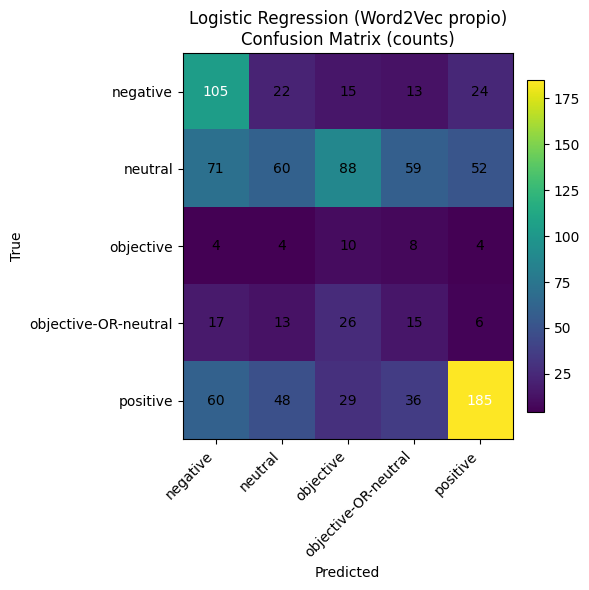

In [73]:
logreg = LogisticRegression(
    max_iter=10000,
    class_weight="balanced"
)

logreg.fit(X_train_pre, y_train)
y_pred_lr = logreg.predict(X_test_pre)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

cm = plot_confusion_matrix(
    y_test, y_pred_lr,
    class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
    title_prefix="Logistic Regression (Word2Vec propio)"
)


Accuracy: 0.40349075975359344
                      precision    recall  f1-score   support

            negative       0.41      0.59      0.48       179
             neutral       0.43      0.11      0.17       330
           objective       0.06      0.37      0.10        30
objective-OR-neutral       0.17      0.18      0.18        77
            positive       0.62      0.64      0.63       358

            accuracy                           0.40       974
           macro avg       0.34      0.38      0.31       974
        weighted avg       0.46      0.40      0.39       974

Linear SVC — classification report
                      precision    recall  f1-score   support

            negative      0.409     0.587     0.482       179
             neutral      0.427     0.106     0.170       330
           objective      0.059     0.367     0.102        30
objective-OR-neutral      0.173     0.182     0.177        77
            positive      0.618     0.637     0.627       358



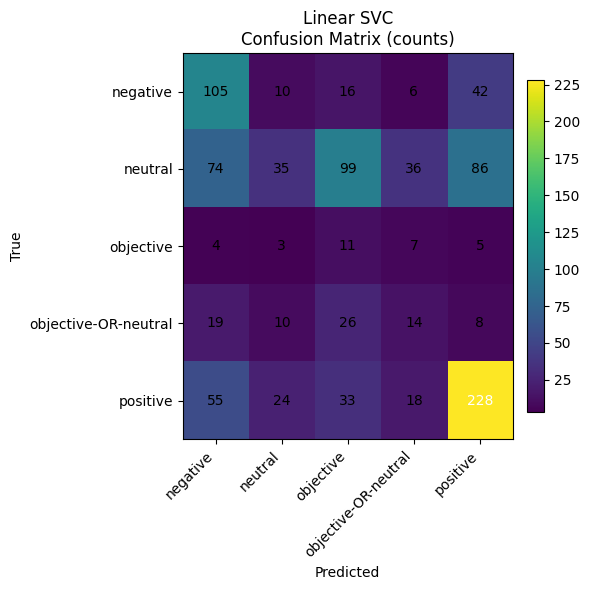

In [74]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_pre, y_train)
y_pred_svm = svm.predict(X_test_pre)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC")

Accuracy: 0.3788501026694045
                      precision    recall  f1-score   support

            negative       0.52      0.07      0.12       179
             neutral       0.33      0.01      0.02       330
           objective       0.15      0.30      0.20        30
objective-OR-neutral       0.05      0.03      0.03        77
            positive       0.41      0.96      0.57       358

            accuracy                           0.38       974
           macro avg       0.29      0.27      0.19       974
        weighted avg       0.37      0.38      0.25       974

Random Forest — classification report
                      precision    recall  f1-score   support

            negative      0.522     0.067     0.119       179
             neutral      0.333     0.009     0.018       330
           objective      0.150     0.300     0.200        30
objective-OR-neutral      0.051     0.026     0.034        77
            positive      0.407     0.958     0.571       358

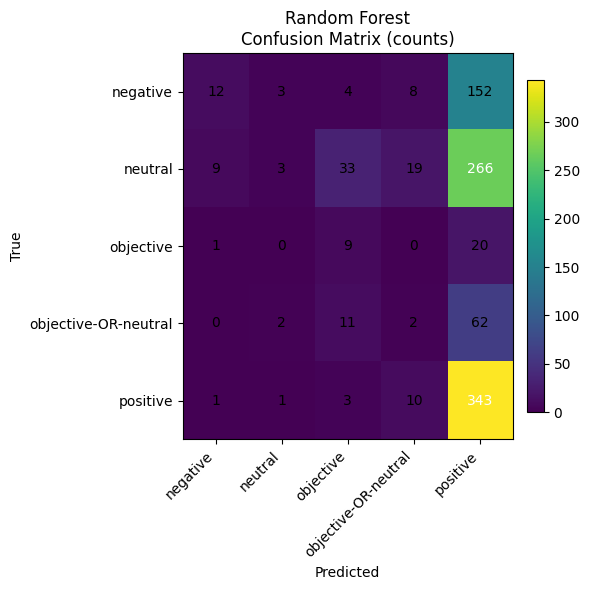

In [75]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    max_depth=None,
    n_jobs=-1,
    random_state=0
)

rf.fit(X_train_pre, y_train)
y_pred_rf = rf.predict(X_test_pre)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm = plot_confusion_matrix(
    y_test, y_pred_rf,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="Random Forest"
)

## Modelo BERT

Para incorporar información contextual profunda y relaciones semánticas a nivel de secuencia, utilizaremos un modelo basado en BERT, el cual emplea mecanismos de atención para capturar dependencias entre palabras sin necesidad de representaciones manuales como N-gramas o embeddings estáticos. Este enfoque permite obtener vectores altamente informativos para cada texto, derivados de un modelo entrenado en grandes cantidades de datos.

Usando BERT como extractor de características

En este escenario emplearemos BERT únicamente para generar embeddings de oraciones, sin ajustar sus pesos internos. Una vez obtenidos los vectores finales, los usaremos como entrada para clasificadores tradicionales. Esto permite evaluar cómo se comportan diferentes algoritmos cuando reciben representaciones contextuales generadas por un transformer. Los clasificadores seleccionados son:

- Logistic Regression
- SVM Lineal
- Random Forest

Estos modelos funcionan bien con embeddings densos de alta calidad. Los lineales suelen ser muy eficientes, mientras que las redes neuronales pueden captar relaciones adicionales en los vectores generados por BERT.

In [80]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

def encode_texts_bert(texts, tokenizer, model, device, batch_size=16, max_length=128):
    all_embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            enc = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Usamos el embedding del token [CLS]
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch, hidden_size)

            all_embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)  # (num_docs, hidden_size)

X_train_bert = encode_texts_bert(
    X_train_texts,
    tokenizer,
    bert_model,
    device,
    batch_size=16,
    max_length=128
)

X_test_bert = encode_texts_bert(
    X_test_texts,
    tokenizer,
    bert_model,
    device,
    batch_size=16,
    max_length=128
)


Accuracy: 0.37782340862423
                      precision    recall  f1-score   support

            negative       0.42      0.53      0.47       179
             neutral       0.40      0.19      0.26       330
           objective       0.05      0.23      0.08        30
objective-OR-neutral       0.10      0.21      0.13        77
            positive       0.65      0.52      0.58       358

            accuracy                           0.38       974
           macro avg       0.32      0.34      0.30       974
        weighted avg       0.46      0.38      0.40       974

Logistic Regression (BERT embeddings) — classification report
                      precision    recall  f1-score   support

            negative      0.419     0.531     0.468       179
             neutral      0.398     0.194     0.261       330
           objective      0.052     0.233     0.085        30
objective-OR-neutral      0.098     0.208     0.133        77
            positive      0.648     0.5

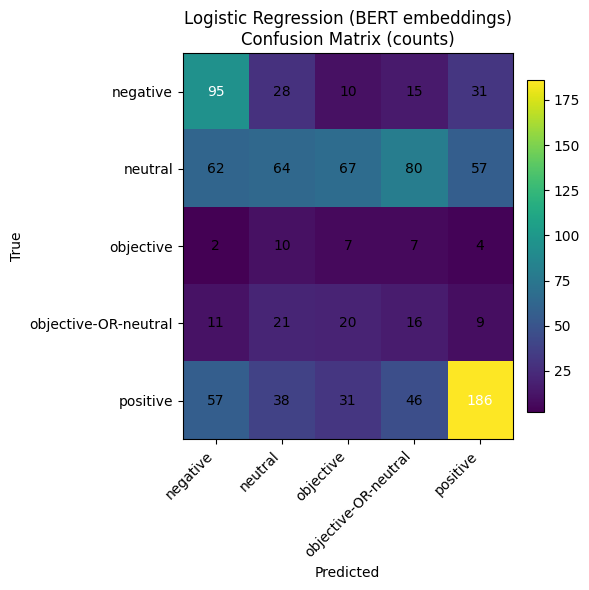

In [81]:
logreg_bert = LogisticRegression(
    max_iter=10000,
    class_weight="balanced",
    n_jobs=-1
)

logreg_bert.fit(X_train_bert, y_train)
y_pred_bert = logreg_bert.predict(X_test_bert)

print("Accuracy:", accuracy_score(y_test, y_pred_bert))
print(classification_report(y_test, y_pred_bert))

cm = plot_confusion_matrix(
    y_test, y_pred_bert,
    class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
    title_prefix="Logistic Regression (BERT embeddings)"
)


Accuracy: 0.4024640657084189
                      precision    recall  f1-score   support

            negative       0.40      0.50      0.45       179
             neutral       0.45      0.20      0.27       330
           objective       0.07      0.30      0.11        30
objective-OR-neutral       0.13      0.23      0.17        77
            positive       0.62      0.59      0.60       358

            accuracy                           0.40       974
           macro avg       0.33      0.36      0.32       974
        weighted avg       0.46      0.40      0.41       974

Linear SVC (BERT embeddings) — classification report
                      precision    recall  f1-score   support

            negative      0.405     0.497     0.446       179
             neutral      0.445     0.197     0.273       330
           objective      0.069     0.300     0.112        30
objective-OR-neutral      0.134     0.234     0.171        77
            positive      0.615     0.589     

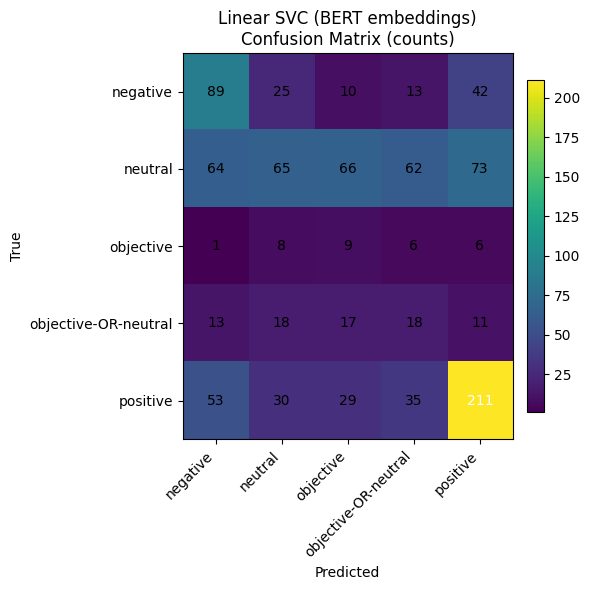

In [82]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_bert, y_train)
y_pred_svm = svm.predict(X_test_bert)

# Después de entrenar y obtener y_pred:
# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = plot_confusion_matrix(y_test, y_pred_svm,
                           class_names=[
                               "negative", "neutral", "objective", "objective-OR-neutral", "positive"],
                           title_prefix="Linear SVC (BERT embeddings)")

Accuracy: 0.3737166324435318
                      precision    recall  f1-score   support

            negative       0.57      0.07      0.12       179
             neutral       0.50      0.02      0.04       330
           objective       0.07      0.13      0.09        30
objective-OR-neutral       0.10      0.04      0.06        77
            positive       0.40      0.95      0.56       358

            accuracy                           0.37       974
           macro avg       0.33      0.24      0.17       974
        weighted avg       0.43      0.37      0.25       974

Random Forest (BERT embeddings) — classification report
                      precision    recall  f1-score   support

            negative      0.571     0.067     0.120       179
             neutral      0.500     0.018     0.035       330
           objective      0.071     0.133     0.093        30
objective-OR-neutral      0.100     0.039     0.056        77
            positive      0.396     0.947  

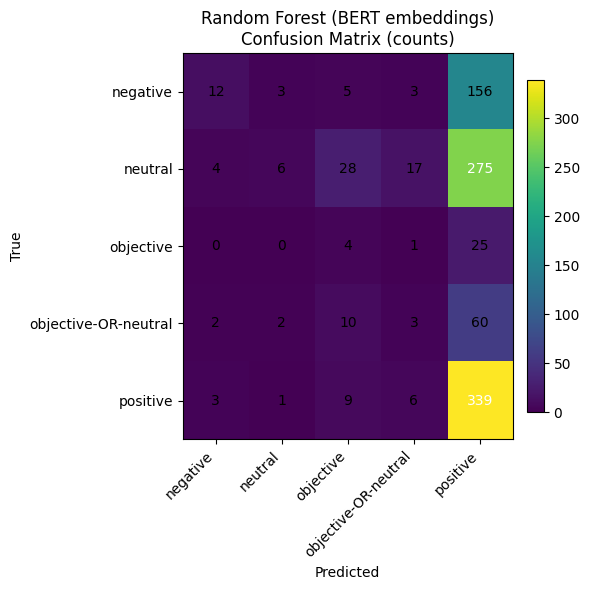

In [83]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    max_depth=None,
    n_jobs=-1,
    random_state=0
)

rf.fit(X_train_bert, y_train)
y_pred_rf = rf.predict(X_test_bert)

# --- EVAL ---
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm = plot_confusion_matrix(
    y_test, y_pred_rf,
    class_names=["negative","neutral","objective","objective-OR-neutral","positive"],
    title_prefix="Random Forest (BERT embeddings)"
)

## Ensamble de Representaciones

Como propuesta final, se utilizó un ensamble de representaciones basado únicamente en las dos técnicas que mostraron el mejor desempeño individual en los experimentos previos:

- Bag of Words (BoW)
- TF-IDF

En lugar de entrenar modelos separados, ambas representaciones se combinaron en un solo vector final por documento, permitiendo que un único clasificador aprovechara simultáneamente la información proporcionada por cada técnica. Esta combinación integra tanto la señal basada en presencia y frecuencia absoluta de términos (BoW) como la relevancia ponderada de las palabras dentro del corpus (TF-IDF).

**Justificación del Ensamble**

La motivación detrás de este ensamble es aprovechar las fortalezas complementarias de ambas representaciones:

- BoW identifica términos clave basándose en su frecuencia directa, lo que suele funcionar bien cuando ciertas palabras son fuertes indicadores de clase.
- TF-IDF reduce el peso de términos demasiado frecuentes y resalta palabras más informativas, lo que ayuda a distinguir mejor entre clases cuando hay ruido o palabras comunes.

Al concatenar ambas vistas del texto, el clasificador obtiene una representación más rica y equilibrada que cualquiera de las dos por separado. Esto permite capturar tanto patrones locales basados en conteos como señales más refinadas de relevancia, mejorando la capacidad del modelo para generalizar.

**Escalamiento y Normalización**

Dado que BoW y TF-IDF operan en escalas distintas, se normalizaron de forma independiente antes de concatenarlas. Esto se hizo con normalización L2 por documento para asegurar que ninguna de las dos representaciones domine numéricamente a la otra. Después de la normalización, ambas matrices se concatenaron horizontalmente para formar la representación final utilizada por un único clasificador (por ejemplo, Linear SVC o Regresión Logística).

Con este procedimiento, se logra un ensamble estable, consistente y directamente basado en las mejores técnicas identificadas en los experimentos previos.

Accuracy (BoW + TF-IDF ensamble): 0.41786447638603696
                      precision    recall  f1-score   support

            negative       0.48      0.35      0.41       179
             neutral       0.42      0.25      0.31       330
           objective       0.05      0.20      0.08        30
objective-OR-neutral       0.15      0.31      0.20        77
            positive       0.63      0.65      0.64       358

            accuracy                           0.42       974
           macro avg       0.35      0.35      0.33       974
        weighted avg       0.48      0.42      0.43       974

Linear SVC (BoW + TF-IDF) — classification report
                      precision    recall  f1-score   support

            negative      0.481     0.352     0.406       179
             neutral      0.421     0.252     0.315       330
           objective      0.050     0.200     0.081        30
objective-OR-neutral      0.151     0.312     0.203        77
            positive    

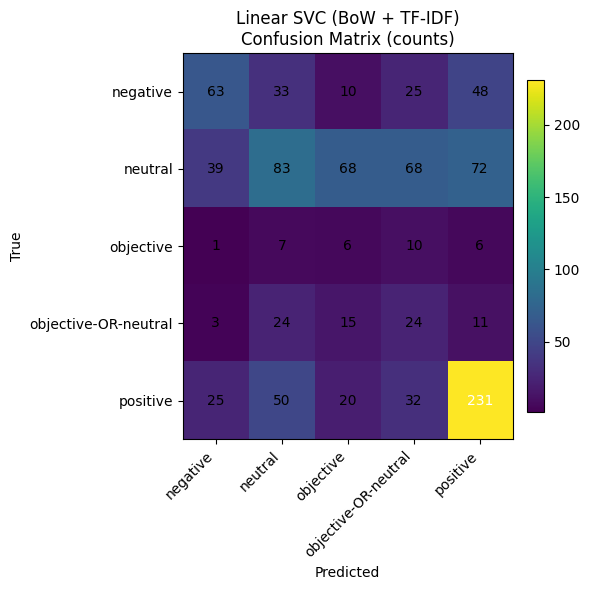

In [86]:
# --- BoW ---
bow = CountVectorizer(
    binary=False,
    token_pattern=r"(?u)\b\w[\w']+\b"
)
X_train_bow = bow.fit_transform(X_train_texts)
X_test_bow  = bow.transform(X_test_texts)

# --- TF-IDF ---
tfidf = TfidfVectorizer(
    token_pattern=r"(?u)\b\w[\w']+\b",
    sublinear_tf=True,
    use_idf=True,
)
X_train_tfidf = tfidf.fit_transform(X_train_texts)
X_test_tfidf  = tfidf.transform(X_test_texts)

# --- Normalizar cada representación por separado (L2 por documento) ---
X_train_bow_n   = normalize(X_train_bow, norm="l2", axis=1)
X_test_bow_n    = normalize(X_test_bow, norm="l2", axis=1)
X_train_tfidf_n = normalize(X_train_tfidf, norm="l2", axis=1)
X_test_tfidf_n  = normalize(X_test_tfidf, norm="l2", axis=1)

# --- Ensamble de representaciones: concatenar BoW + TF-IDF ---
X_train_ens = hstack([X_train_bow_n, X_train_tfidf_n])
X_test_ens  = hstack([X_test_bow_n,  X_test_tfidf_n])

# --- MODELO ÚNICO SOBRE LA COMBINACIÓN ---

# Opción 1: Linear SVC (recomendado para alta dimensionalidad)
clf = LinearSVC(class_weight="balanced")
# Opción 2 (si prefieres LogReg):
# clf = LogisticRegression(max_iter=10000, class_weight="balanced")

clf.fit(X_train_ens, y_train)
y_pred_ens = clf.predict(X_test_ens)

print("Accuracy (BoW + TF-IDF ensamble):", accuracy_score(y_test, y_pred_ens))
print(classification_report(y_test, y_pred_ens))

cm = plot_confusion_matrix(
    y_test, y_pred_ens,
    class_names=["negative", "neutral", "objective", "objective-OR-neutral", "positive"],
    title_prefix="Linear SVC (BoW + TF-IDF)"
)


## Conclusión

En contraste, las representaciones más simples —Bag of Words y TF-IDF— demostraron ser más eficaces y consistentes. Su rendimiento se mantuvo estable y, en varios casos, superó a las técnicas más elaboradas. Esto confirma un patrón común en tareas de clasificación de texto: cuando el conjunto de datos no es muy grande o no presenta suficiente variabilidad lingüística, los modelos sencillos suelen generalizar mejor y evitar el ruido que generan las características excesivamente específicas de los n-gramas más amplios.

Asimismo, los clasificadores Regresión Logística y Linear SVC fueron los que ofrecieron mejores resultados, mostrando mayor estabilidad y métricas más equilibradas en comparación con otros modelos como Naive Bayes o Árboles de Decisión. Ambos algoritmos se benefician particularmente de representaciones como TF-IDF o BoW, donde las relaciones lineales entre características y clases son más evidentes.

En conjunto, los resultados sugieren que no siempre lo más complejo es mejor. Para este caso, la combinación de representaciones simples y clasificadores lineales no solo fue suficiente, sino también la opción más efectiva, demostrando que la simplicidad bien fundamentada puede superar a la sofisticación innecesaria.

También considero que la gran cantidad de clases similares influye  en las métricas, haciendo que no fueran tan altas. Cuando varias clases comparten características lingüísticas muy parecidas, los modelos tienden a confundirse con mayor facilidad. Además, existe un sesgo evidente en la distribución de ejemplos: algunas clases cuentan con muchos más datos que otras, mientras que ciertas categorías están subrepresentadas. Esta desproporción afecta el entrenamiento, favoreciendo a las clases con mayor cantidad de muestras y perjudicando el desempeño en aquellas con pocos ejemplos, lo que contribuye a la variabilidad y a la disminución de las métricas globales.